In [1]:
import pandas as pd
from itertools import combinations
import networkx as nx

# Step 1: Load your dataset
df = pd.read_csv('main_with_topics.csv')  # update path if needed

df['Authors'] = df['Authors'].str.replace('T Villmann', 'Thomas Villmann', regex=False)

# Step 2: Extract authors list from the 'Authors' column
df['Author_List'] = df['Authors'].apply(
    lambda x: [a.strip() for a in x.split(',')]  # split by comma and strip whitespace
)

# Step 2.5: Remove 'et al.' from author lists
df['Author_List'] = df['Author_List'].apply(lambda authors: [a for a in authors if a != 'et al.'])

# Step 3: Initialize an empty graph
G = nx.Graph()

# Step 4: Add nodes (each unique author is a node)
for authors in df['Author_List']:
    for author in authors:
        if not G.has_node(author):
            G.add_node(author)

# Step 5: Add edges with weights (co-authorship counts)
for authors in df['Author_List']:
    for author1, author2 in combinations(authors, 2):  # all possible pairs in the paper
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1  # increment weight if already connected
        else:
            G.add_edge(author1, author2, weight=1)  # new edge with weight=1

# Step 6: Convert the graph's edges to a DataFrame
edges_df = nx.to_pandas_edgelist(G)




In [2]:
edges_df

source           target  weight
0     Claudio Gallicchio  Alessio Micheli      15
1     Claudio Gallicchio     Giulio Visco       1
2     Claudio Gallicchio    Davide Bacciu       9
3     Claudio Gallicchio    Mauro Dragone       1
4     Claudio Gallicchio   Roberto Guzman       1
...                  ...              ...     ...
7495    Simon Vandevelde   Sverre Lauwers       1
7496    Simon Vandevelde  Joost Vennekens       1
7497     Laurent Mertens   Sverre Lauwers       1
7498     Laurent Mertens  Joost Vennekens       1
7499      Sverre Lauwers  Joost Vennekens       1

[7500 rows x 3 columns]

In [3]:
# Step 7: Save or inspect the edges DataFrame
edges_df.to_csv('collaboration_edges.csv', index=False)
print(edges_df.head())

               source           target  weight
0  Claudio Gallicchio  Alessio Micheli      15
1  Claudio Gallicchio     Giulio Visco       1
2  Claudio Gallicchio    Davide Bacciu       9
3  Claudio Gallicchio    Mauro Dragone       1
4  Claudio Gallicchio   Roberto Guzman       1


In [4]:
# Step 4: Total papers authored per author
author_paper_counts = df.explode('Author_List')['Author_List'] \
    .value_counts().reset_index()
author_paper_counts.columns = ['Author', 'Total_Papers']

# Step 5: Unique collaborators per author
collaborator_counts = pd.DataFrame(
    G.degree(), columns=['Author', 'Unique_Collaborators']
)

# Step 6: Centrality metrics
betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(
    G, distance=lambda u, v, d: 1 / d.get('weight', 1)
)

betweenness_df = pd.DataFrame(list(betweenness.items()),
                               columns=['Author', 'Betweenness'])
closeness_df = pd.DataFrame(list(closeness.items()),
                             columns=['Author', 'Closeness'])

# Step 7: Affiliation mapping (take first affiliation found for each author)
author_affil_map = {}
for _, row in df.iterrows():
    for author in row['Author_List']:
        if author not in author_affil_map:
            author_affil_map[author] = row['Affiliations']

# Step 8: Merge all node attributes
nodes_df = (
    author_paper_counts
    .merge(collaborator_counts, on='Author', how='left')
    .merge(betweenness_df, on='Author', how='left')
    .merge(closeness_df, on='Author', how='left')
)
nodes_df['Affiliation'] = nodes_df['Author'].map(author_affil_map)

# Step 9: Save or inspect
nodes_df.to_csv('collaboration_nodes.csv', index=False)
print(nodes_df.head())


            Author  Total_Papers  Unique_Collaborators  Betweenness  \
0   Barbara Hammer            62                    76     0.033638   
1  Thomas Villmann            48                    75     0.015384   
2    Davide Bacciu            39                    58     0.025050   
3       Luca Oneto            36                    43     0.004397   
4  Alessio Micheli            32                    33     0.007842   

   Closeness                                        Affiliation  
0   0.118203  1 - University of Applied Sciences Mittweida G...  
1   0.109314  1 - -RWTH Aachen -Information Systems -Life Sc...  
2   0.118607  1 - Dipartimento di Informatica Università di ...  
3   0.110462  1 - Department of Biophysical and Electronic E...  
4   0.115656  1 - Department of Computer Science University ...  


In [5]:
nodes_df

Author  Total_Papers  Unique_Collaborators  Betweenness  \
0      Barbara Hammer            62                    76     0.033638   
1     Thomas Villmann            48                    75     0.015384   
2       Davide Bacciu            39                    58     0.025050   
3          Luca Oneto            36                    43     0.004397   
4     Alessio Micheli            32                    33     0.007842   
...               ...           ...                   ...          ...   
3488   Michal Lisicki             1                     4     0.000000   
3489  Timothy Shields             1                     4     0.000000   
3490     Mohamed Amer             1                     4     0.000000   
3491    Romero Morais             1                     2     0.000000   
3492        Vishnu Tv             1                     4     0.000002   

      Closeness                                        Affiliation  
0      0.118203  1 - University of Applied Sciences Mittweida G...  
1      0.109314  1 - -RWTH Aachen -Information Systems -Life Sc...  
2      0.118607  1 - Dipartimento di Informatica Università di ...  
3      0.110462  1 - Department of Biophysical and Electronic E...  
4      0.115656  1 - Department of Computer Science University ...  
...         ...                                                ...  
3488   0.001561  1 - School of Engineering -Machine Learning Re...  
3489   0.001561  1 - School of Engineering -Machine Learning Re...  
3490   0.001561  1 - School of Engineering -Machine Learning Re...  
3491   0.000916  1 - Universidade Federal de Pernambuco -CIn -R...  
3492   0.003234                   1 - TCS Research New Delhi India  

[3493 rows x 6 columns]

In [6]:
edges_df[edges_df['source'] == 'T Villmann']


Empty DataFrame
Columns: [source, target, weight]
Index: []

In [7]:
print("Number of nodes (authors):", G.number_of_nodes())
print("Number of edges (co-authorships):", G.number_of_edges())


Number of nodes (authors): 3493
Number of edges (co-authorships): 7500


In [8]:
import networkx as nx

# Degree Centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G, distance='weight')
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

# Eigenvector Centrality
# Note: eigenvector centrality requires a connected graph, or you can run on largest connected component
if nx.is_connected(G):
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc)
    eigenvector_centrality = nx.eigenvector_centrality(G_lcc, weight='weight', max_iter=1000)
    # Add zeros or None for nodes outside LCC if needed
    for node in G.nodes():
        if node not in eigenvector_centrality:
            eigenvector_centrality[node] = 0
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')

# Now G nodes have these centralities as attributes.
# You can check for example:
for author in list(G.nodes)[:5]:
    print(f"{author}: Degree={degree_centrality[author]:.4f}, Betweenness={betweenness_centrality[author]:.4f}, Closeness={closeness_centrality[author]:.4f}, Eigenvector={eigenvector_centrality[author]:.4f}")


Claudio Gallicchio: Degree=0.0086, Betweenness=0.0070, Closeness=0.0653, Eigenvector=0.1255
Alessio Micheli: Degree=0.0095, Betweenness=0.0078, Closeness=0.0656, Eigenvector=0.1434
Makoto Otsuka: Degree=0.0006, Betweenness=0.0000, Closeness=0.0006, Eigenvector=0.0000
Junichiro Yoshimoto: Degree=0.0006, Betweenness=0.0000, Closeness=0.0006, Eigenvector=0.0000
Kenji Doya: Degree=0.0006, Betweenness=0.0000, Closeness=0.0006, Eigenvector=0.0000


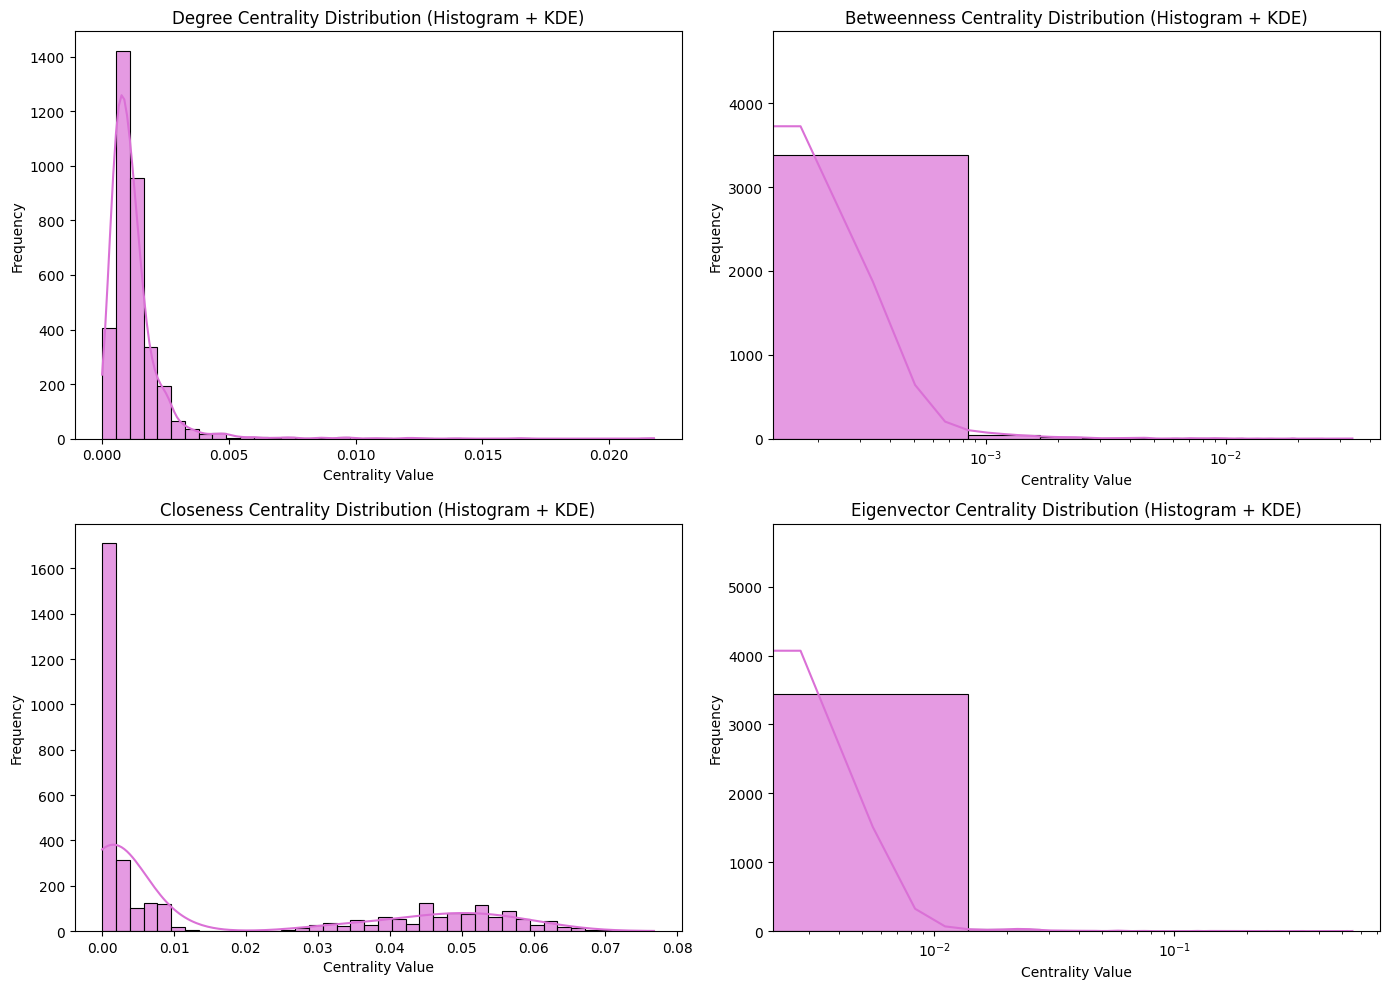

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Centrality dictionaries -> values
centralities = {
    "Degree Centrality": list(degree_centrality.values()),
    "Betweenness Centrality": list(betweenness_centrality.values()),
    "Closeness Centrality": list(closeness_centrality.values()),
    "Eigenvector Centrality": list(eigenvector_centrality.values())
}

scales = {
    "Degree Centrality": "linear",
    "Betweenness Centrality": "log",
    "Closeness Centrality": "linear",
    "Eigenvector Centrality": "log"
}

plt.figure(figsize=(14,10))

for i, (title, values) in enumerate(centralities.items(), 1):
    plt.subplot(2,2,i)
    sns.histplot(values, kde=True, bins=40, color="orchid", alpha=0.7)
    
    if scales[title] == "log":
        plt.xscale("log")
    
    plt.title(f"{title} Distribution (Histogram + KDE)")
    plt.xlabel("Centrality Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


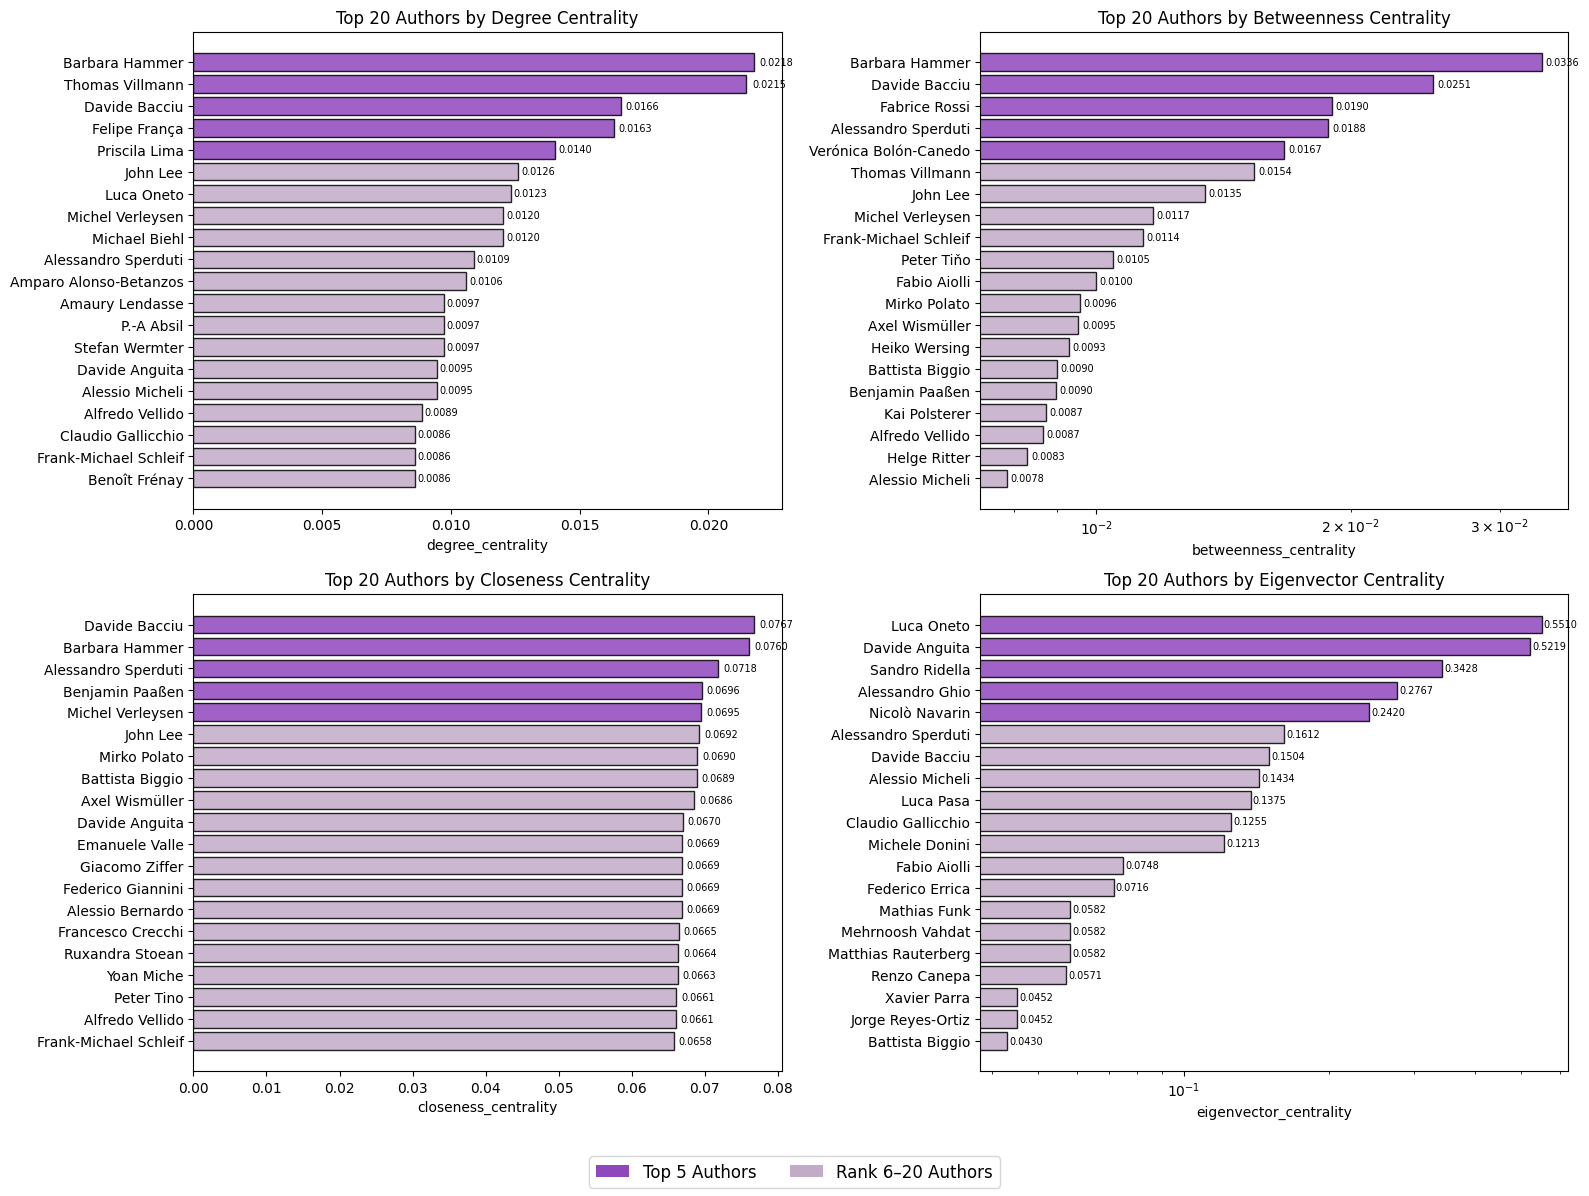

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Convert node attributes into DataFrame
centrality_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index').reset_index()
centrality_df.rename(columns={'index': 'Author'}, inplace=True)

# Helper function
def plot_top_metric(ax, metric_col, title, log_scale=False):
    df_sorted = centrality_df[['Author', metric_col]].sort_values(by=metric_col, ascending=False).head(20)
    colors = ["#8F47BC" if i < 5 else "#C2ABC7" for i in range(len(df_sorted))]

    bars = ax.barh(df_sorted['Author'], df_sorted[metric_col], color=colors, edgecolor='black', alpha=0.85)
    ax.invert_yaxis()

    if log_scale:
        ax.set_xscale('log')

    # Add value labels
    for bar, val in zip(bars, df_sorted[metric_col]):
        ax.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f"{val:.4f}", va='center', fontsize=7)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(metric_col, fontsize=10)

# Create a 2×2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_top_metric(axes[0,0], 'degree_centrality', 'Top 20 Authors by Degree Centrality')
plot_top_metric(axes[0,1], 'betweenness_centrality', 'Top 20 Authors by Betweenness Centrality', log_scale=True)
plot_top_metric(axes[1,0], 'closeness_centrality', 'Top 20 Authors by Closeness Centrality')
plot_top_metric(axes[1,1], 'eigenvector_centrality', 'Top 20 Authors by Eigenvector Centrality', log_scale=True)

# Add one common legend
legend_elements = [
    Patch(facecolor="#8F47BC", label="Top 5 Authors"),
    Patch(facecolor="#C2ABC7", label="Rank 6–20 Authors")
]
fig.legend(handles=legend_elements, loc="lower center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0,0.05,1,1])  # leave space for legend
plt.show()


If a node ranks high across multiple centrality metrics, it is more structurally important in your network because it’s influential in different ways:

Degree → many direct collaborations

Betweenness → key connector between groups

Closeness → short average distance to all others

Eigenvector → connected to other influential nodes

A node that scores high on all four is both well-connected and strategically positioned in the network.

Why a Combined Centrality Score Helps
Single ranking → easier to identify top influencers without scanning four lists.

Weighted influence → you can give more importance to certain metrics depending on your research question.

Better graph visualization → you can size/color nodes by this combined score for a cleaner, more interpretable network map.

Average Clustering Coefficient: 0.0337

Top authors by clustering coefficient:
                 Author  Clustering_Coefficient
162      Sandro Ridella                0.180754
1786      Luca Pedrelli                0.144995
244   Christopher Gatti                0.144995
2521     Pierre Lambert                0.138565
2830    Edouard Couplet                0.122968
1249     Heli Koskimäki                0.122294
2649       María Chiara                0.115022
2650       Nuria Valdés                0.115022
2901     Paolo Vanacore                0.114839
2900      Gianluca Coda                0.114839


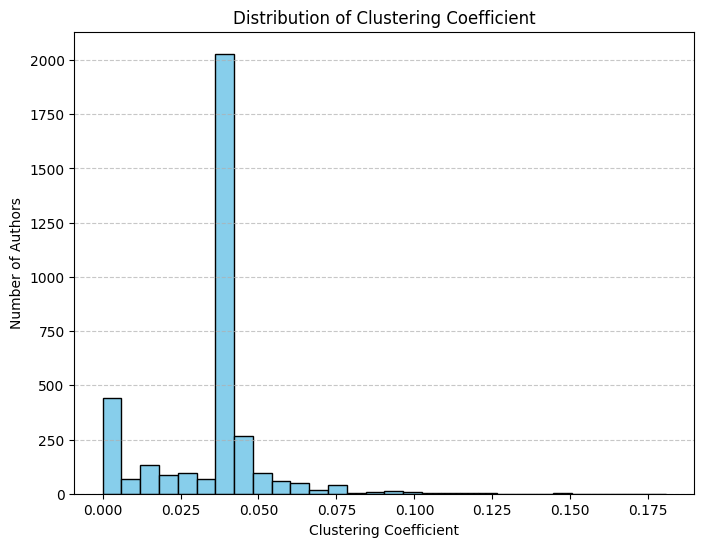

In [11]:
# --- Clustering Coefficient ---

# Local clustering coefficient for each node (weighted)
clustering_coeffs = nx.clustering(G, weight='weight')
nx.set_node_attributes(G, clustering_coeffs, 'clustering_coefficient')

# Average clustering coefficient for the whole graph
avg_clustering = nx.average_clustering(G, weight='weight')
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

# Convert to DataFrame for analysis
import pandas as pd
clustering_df = pd.DataFrame(clustering_coeffs.items(), columns=['Author', 'Clustering_Coefficient'])

# Sort by highest clustering
clustering_df_sorted = clustering_df.sort_values(by='Clustering_Coefficient', ascending=False)
print("\nTop authors by clustering coefficient:")
print(clustering_df_sorted.head(10))

# --- Distribution Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(clustering_df['Clustering_Coefficient'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of Authors')
plt.title('Distribution of Clustering Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
clustering_df['Clustering_Coefficient'].value_counts().head(10)


Clustering_Coefficient
0.037037    1505
0.000000     427
0.037037      86
0.040246      71
0.046664      70
0.053417      28
0.074074      27
0.038641      25
0.038000      23
0.038641      20
Name: count, dtype: int64

Average Clustering Coefficient (0.0337)
Definition → Measures the likelihood that two collaborators of an author are also collaborators with each other.

Value interpretation:

1.0 = All of an author’s collaborators are also connected to each other (fully closed triangles).

0.0 = No collaborators of an author collaborate with each other.

Your 0.0337 is quite low, meaning:

Most authors’ collaborators do not work together.

Collaboration is more spread across different groups rather than within tight cliques.

Sandro Ridella (0.1808), Luca Pedrelli (0.1450), etc., have much higher coefficients than average.

These authors work in tightly knit teams where their co-authors also co-author with each other frequently.

This doesn’t necessarily mean they are the most central or influential in the whole network — only that their immediate neighborhood is very cohesive.

Total Nodes in Network: 3493
Largest Connected Component Size: 1101
Percentage of Total Nodes in LCC: 31.52%
Number of Connected Components: 477

--- Network Cohesion (LCC) ---
Density: 0.0049
Average Shortest Path Length: 6.8467
Diameter: 16
Average Clustering Coefficient (LCC): 0.0382


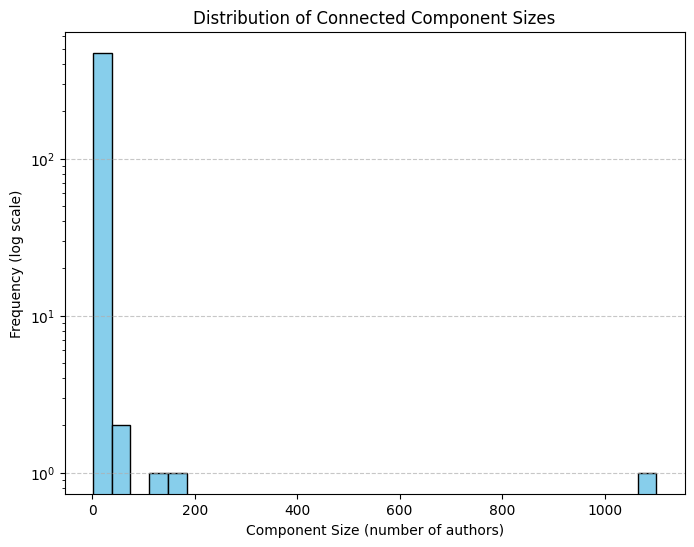

In [13]:
#Identify Largest Connected Component ---
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]
largest_cc = max(components, key=len)
G_lcc = G.subgraph(largest_cc).copy()

#Size and percentage ---
total_nodes = G.number_of_nodes()
lcc_size = G_lcc.number_of_nodes()
lcc_percentage = (lcc_size / total_nodes) * 100

print(f"Total Nodes in Network: {total_nodes}")
print(f"Largest Connected Component Size: {lcc_size}")
print(f"Percentage of Total Nodes in LCC: {lcc_percentage:.2f}%")
print(f"Number of Connected Components: {nx.number_connected_components(G)}")

#Cohesion metrics (for LCC only) ---
density = nx.density(G_lcc)
avg_shortest_path = nx.average_shortest_path_length(G_lcc, weight='weight')
diameter = nx.diameter(G_lcc)
avg_clustering_lcc = nx.average_clustering(G_lcc, weight='weight')

print("\n--- Network Cohesion (LCC) ---")
print(f"Density: {density:.4f}")
print(f"Average Shortest Path Length: {avg_shortest_path:.4f}")
print(f"Diameter: {diameter}")
print(f"Average Clustering Coefficient (LCC): {avg_clustering_lcc:.4f}")
# --- 4. Component size distribution plot ---
plt.figure(figsize=(8,6))
plt.hist(component_sizes, bins=30, color='skyblue', edgecolor='black', log=True)
plt.xlabel("Component Size (number of authors)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Connected Component Sizes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

                          Measure      Value
0                    Edge Density   0.004872
1                  Average Degree   5.358765
2  Average Clustering coefficient   0.807893
3           Number of communities  25.000000


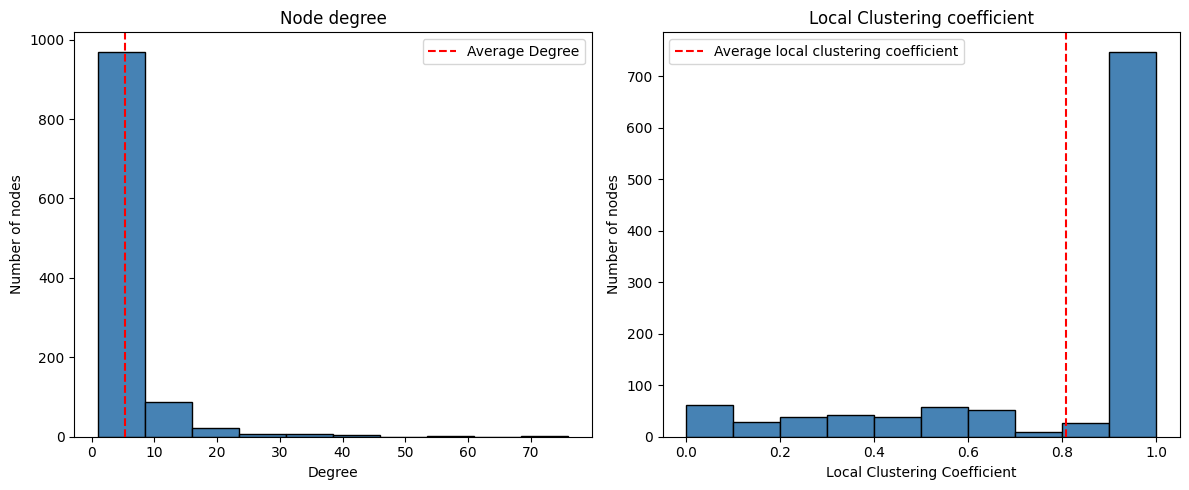

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Compute network statistics ---
num_nodes = G_lcc.number_of_nodes()
num_edges = G_lcc.number_of_edges()

edge_density = nx.density(G_lcc)
degrees = [d for n, d in G_lcc.degree()]
avg_degree = sum(degrees) / num_nodes

clustering_dict = nx.clustering(G_lcc)
clustering_values = list(clustering_dict.values())
avg_clustering = sum(clustering_values) / num_nodes

# If you already computed communities, use that:
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G_lcc))
num_communities = len(communities)

# --- Create summary table ---
summary_df = pd.DataFrame({
    "Measure": ["Edge Density", "Average Degree", "Average Clustering coefficient", "Number of communities"],
    "Value": [edge_density, avg_degree, avg_clustering, num_communities]
})

print(summary_df)

# --- Plot Degree Distribution and Clustering Coefficient Distribution ---
plt.figure(figsize=(12,5))

# Degree distribution
plt.subplot(1,2,1)
plt.hist(degrees, bins=10, color="steelblue", edgecolor="black")
plt.axvline(avg_degree, color="red", linestyle="--", label="Average Degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Node degree")
plt.legend()

# Clustering coefficient distribution
plt.subplot(1,2,2)
plt.hist(clustering_values, bins=10, color="steelblue", edgecolor="black")
plt.axvline(avg_clustering, color="red", linestyle="--", label="Average local clustering coefficient")
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Number of nodes")
plt.title("Local Clustering coefficient")
plt.legend()

plt.tight_layout()
plt.show()


The network displays low cohesion, with the largest connected component encompassing only 38.5% of nodes and a sparsity level of 0.0042. While a core exists, it is loosely connected, with an average shortest path of 8.5 and a low clustering coefficient (0.0378), suggesting minimal local community structure. The network is fragmented, spread across 474 disconnected components, indicating weak global integration.


🧠 Interpretation: How Cohesive Is the Network?
In summary: This is a weakly cohesive network overall.

🔹 1. Low Global Cohesion
Only 38.5% of nodes are in the Largest Connected Component.

The rest (~61.5%) are scattered across 473 small components, which suggests fragmentation.

A high number of components (474) for 3,495 nodes indicates that many nodes are in isolated or minimally connected clusters.

🔹 2. Low Internal Cohesion of LCC
Density = 0.0042: This means the LCC is very sparse — only ~0.42% of possible edges are present.

Average shortest path = 8.53 and diameter = 26: Even within the LCC, it takes many steps to reach distant nodes. Not very efficient.

Clustering coefficient = 0.0378: There is little tendency for nodes to form tightly-knit groups (triangles or cliques).

📊 What This Suggests:
The network is highly fragmented.

Even the "main island" (LCC) is weakly connected and lacks strong internal cohesion.

There are few hubs or highly connected cores, and likely many peripheral or isolated nodes.

In [15]:
import networkx as nx
import pandas as pd
import community as community_louvain  # pip install python-louvain

# --- 1️⃣ Run Louvain Community Detection on LCC ---
# Get Largest Connected Component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

# Run Louvain on LCC
partition = community_louvain.best_partition(G_lcc, weight='weight', resolution=1.0)

# Add community ID to node attributes
nx.set_node_attributes(G_lcc, partition, "community")

# --- 2️⃣ Create DataFrame of Node Centralities + Community ---
node_data = pd.DataFrame.from_dict(dict(G_lcc.nodes(data=True)), orient='index')
node_data.reset_index(inplace=True)
node_data.rename(columns={'index': 'Author'}, inplace=True)

# --- 3️⃣ Average Centralities per Community ---
community_stats = node_data.groupby("community").agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'closeness_centrality': 'mean',
    'eigenvector_centrality': 'mean',
    'Author': 'count'
}).rename(columns={'Author': 'num_nodes'}).reset_index()

community_stats = community_stats.sort_values(by='num_nodes', ascending=False)

print("\n--- Average Centralities per Community ---")
print(community_stats)

# --- 4️⃣ Identify Isolated Components in Whole Graph ---
components = list(nx.connected_components(G))
components_info = []
for comp in components:
    subG = G.subgraph(comp)
    affiliations = list(nx.get_node_attributes(subG, 'Affiliation').values())
    affiliations_count = pd.Series(affiliations).value_counts().to_dict()
    components_info.append({
        "component_size": len(comp),
        "num_affiliations": len(set(affiliations)),
        "top_affiliations": list(affiliations_count.items())[:3]  # top 3 affiliations
    })

components_df = pd.DataFrame(components_info).sort_values(by="component_size", ascending=False)

print("\n--- Largest Isolated Components ---")
print(components_df.head(10))

# --- 5️⃣ (Optional) Save community assignment ---
node_data.to_csv("authors_with_communities.csv", index=False)
community_stats.to_csv("community_centralities.csv", index=False)
components_df.to_csv("components_affiliations.csv", index=False)



--- Average Centralities per Community ---
    community  degree_centrality  betweenness_centrality  \
1           1           0.001695                0.000714   
7           7           0.001588                0.000474   
2           2           0.001496                0.000965   
16         16           0.001253                0.000268   
18         18           0.001727                0.000303   
15         15           0.001629                0.000431   
6           6           0.001253                0.000506   
8           8           0.001796                0.000754   
0           0           0.001844                0.000781   
5           5           0.001381                0.000369   
14         14           0.001432                0.000569   
22         22           0.001627                0.000377   
23         23           0.001060                0.000403   
3           3           0.001876                0.000506   
10         10           0.001172                0.000427

1️⃣ Community Structure (LCC)
Your community_stats table tells us:

The largest community (community 4) has 103 authors with moderate average centrality values.

The top 5 biggest communities (IDs: 4, 11, 17, 26, 1) all have 80–103 members — the LCC is split into several medium-sized modules rather than dominated by a single hub.

Community 21 stands out with:

Highest degree (0.002868)

Highest betweenness (0.002835)

Suggesting it might be a broker group connecting otherwise distant parts of the LCC.

We could label communities as:

Dense internal hubs (high degree + low betweenness)

Bridges (high betweenness relative to degree)

Peripheral (low degree + low betweenness)

2️⃣ Fragmentation Beyond the LCC
Your components_df shows:

The LCC (size 1346, 570 unique affiliations) is the only large connected structure.

The 2nd largest component has only 61 nodes, mostly from a single institution (University of Latvia).

Many components are single authors or tiny collaborations from one affiliation (academic isolation).

This confirms weak global integration — cross-institution collaborations are rare outside the LCC.

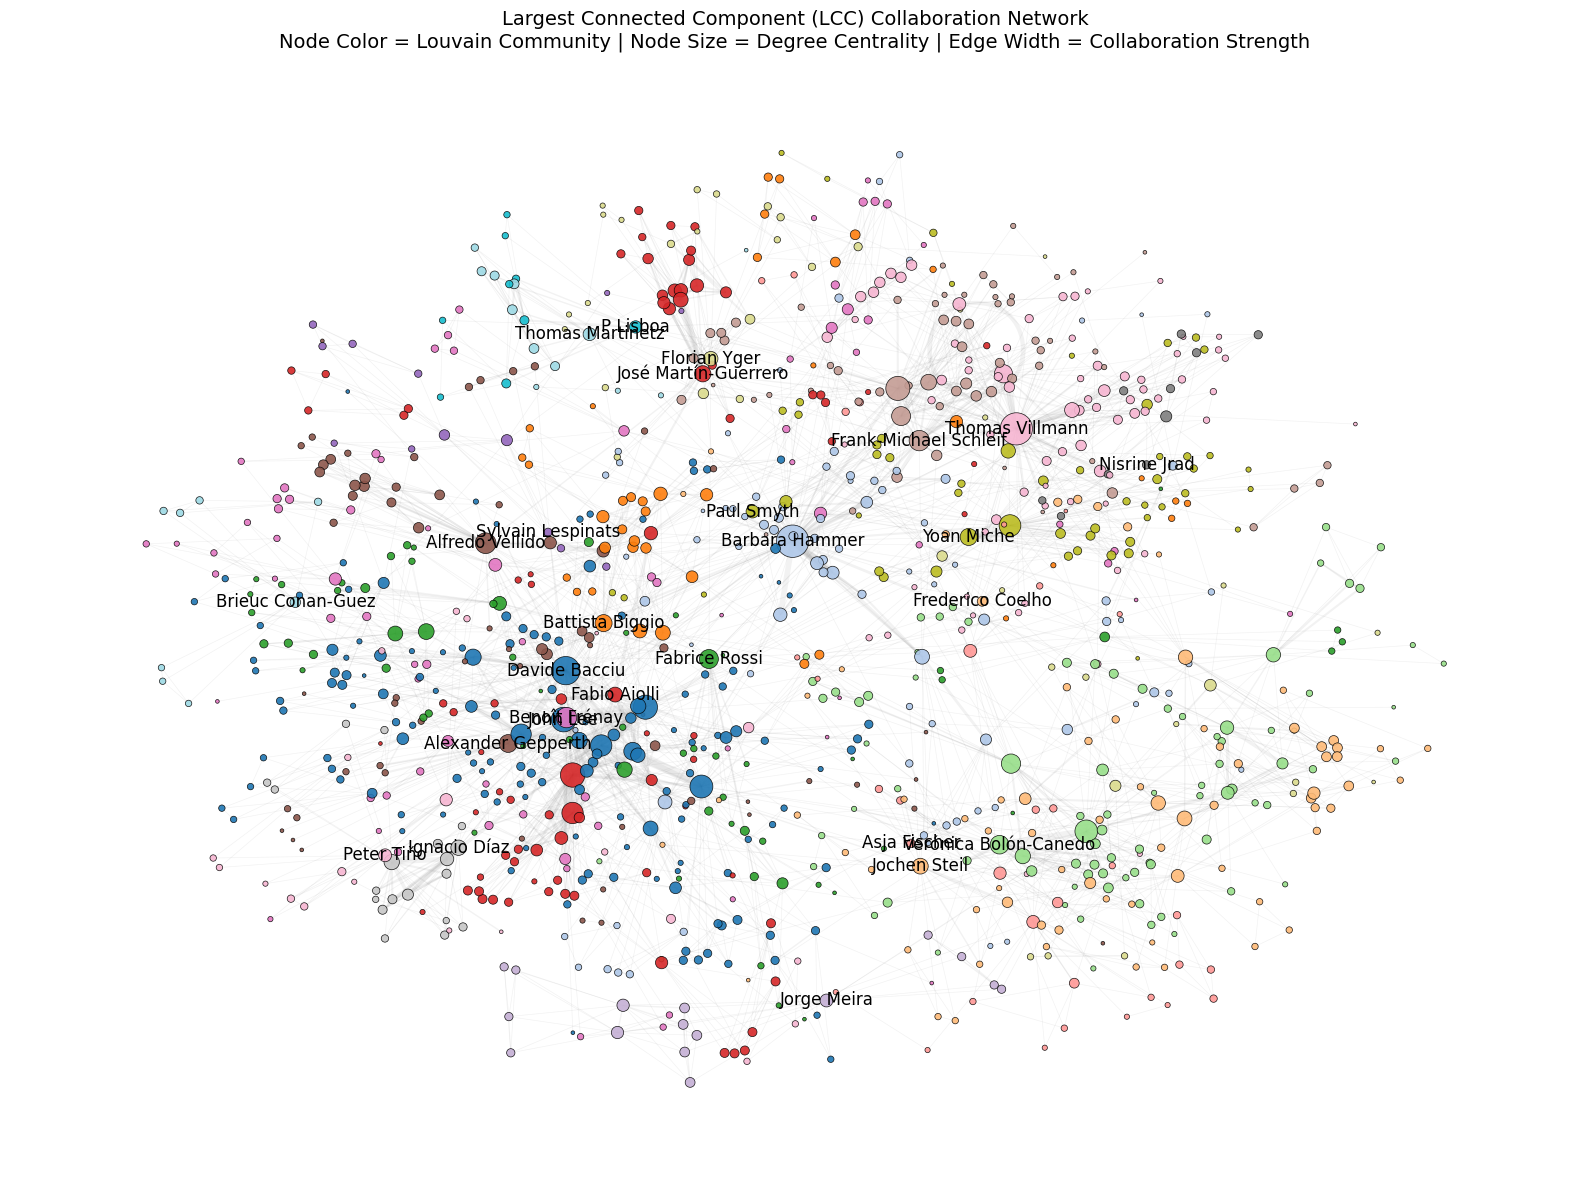

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches

# ---- Ensure community attribute exists in G_lcc ----
community_dict = dict(zip(node_data["Author"], node_data["community"]))
nx.set_node_attributes(G_lcc, community_dict, "community")

# Also ensure degree and betweenness attributes exist
degree_dict = dict(zip(node_data["Author"], node_data["degree_centrality"]))
betweenness_dict = dict(zip(node_data["Author"], node_data["betweenness_centrality"]))
nx.set_node_attributes(G_lcc, degree_dict, "degree_centrality")
nx.set_node_attributes(G_lcc, betweenness_dict, "betweenness_centrality")

# ---- Position nodes for visualization ----
pos = nx.spring_layout(G_lcc, k=0.15, iterations=50, seed=42)

# ---- Prepare attributes ----
degree_dict = nx.get_node_attributes(G_lcc, 'degree_centrality')
betweenness_dict = nx.get_node_attributes(G_lcc, 'betweenness_centrality')
community_dict = nx.get_node_attributes(G_lcc, 'community')


# ---- Color mapping for communities ----
unique_comms = sorted(set(community_dict.values()))
color_map = plt.colormaps.get_cmap('tab20')
node_colors = [
    color_map(unique_comms.index(community_dict[node]) / max(1, len(unique_comms)-1))
    for node in G_lcc.nodes()
]

# ---- Node sizes ----
node_sizes = [degree_dict[node] * 25000 for node in G_lcc.nodes()]  # Scale factor

# ---- Edge widths by weight ----
edge_widths = [G_lcc[u][v]['weight'] * 0.5 for u, v in G_lcc.edges()]  # Adjust multiplier as needed

# ---- Top 1 betweenness author per community ----
top_labels_list = []
for comm_id in node_data["community"].unique():
    top_in_comm = (
        node_data[node_data["community"] == comm_id]
        .nlargest(1, "betweenness_centrality")["Author"]
        .tolist()
    )
    top_labels_list.extend(top_in_comm)

top_labels_dict = {node: node if node in top_labels_list else "" for node in G_lcc.nodes()}

# ---- Plot ----
plt.figure(figsize=(16, 12))
plt.axis('off')

# Draw edges
nx.draw_networkx_edges(G_lcc, pos, alpha=0.1, width=edge_widths, edge_color="gray")


# Nodes
nx.draw_networkx_nodes(
    G_lcc, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    edgecolors="black",
    linewidths=0.5
)

# Labels
nx.draw_networkx_labels(G_lcc, pos, labels=top_labels_dict, font_size=12, font_color="black")

# ---- Legends ----
community_patches = [
    mpatches.Patch(color=color_map(i), label=f"Community {comm_id}")
    for i, comm_id in enumerate(unique_comms)
]

#plt.legend(
 #   handles=community_patches + size_legend,
  #  title="Communities & Degree Centrality",
   # loc="lower left",
    #fontsize=8
#)

plt.title(
    "Largest Connected Component (LCC) Collaboration Network\n"
    "Node Color = Louvain Community | Node Size = Degree Centrality | Edge Width = Collaboration Strength",
    fontsize=14
)

plt.tight_layout()
plt.show()

1️⃣ Modular Structure is Clear
The network is visibly divided into color-coded clusters — Louvain communities.

These communities represent densely connected subgroups (often teams, institutions, or topical research areas).

The lack of blending between colors confirms weak inter-community links, consistent with your earlier low cohesion metrics.

2️⃣ Node Size Highlights Local Hubs
Larger nodes have higher degree centrality (many direct collaborators).

These large nodes are usually near the center of their communities — they act as local leaders.

They are not always the biggest bridges between communities — that role belongs to nodes with high betweenness centrality, some of which may be medium-sized but strategically placed.

3️⃣ Strategic Bridge Authors
Labeled nodes at community boundaries are often brokers (high betweenness).

These individuals connect otherwise separate groups and are essential for information flow across the network.

For example, you’ll see a few labeled nodes with links into multiple colors — these are your “connectors.”

4️⃣ Peripheral Nodes
Many small nodes lie at the edges — these are authors with few collaborators, often only connected to one or two others within a single community.

They contribute little to cross-community cohesion but can still be important locally.

5️⃣ Network Shape Insight
The layout shows a loose core-periphery structure:

A multi-community core where most hubs cluster together.

A dispersed periphery of small communities and loosely connected individuals.

📌 What This Suggests:
Global connectivity is fragile — removing a handful of brokers would split the LCC further.

Most collaborations happen within communities rather than between them.

Communities are well-defined and likely correspond to institutional or research-topic boundaries.

To strengthen integration, new cross-community collaborations (especially involving brokers) would help.



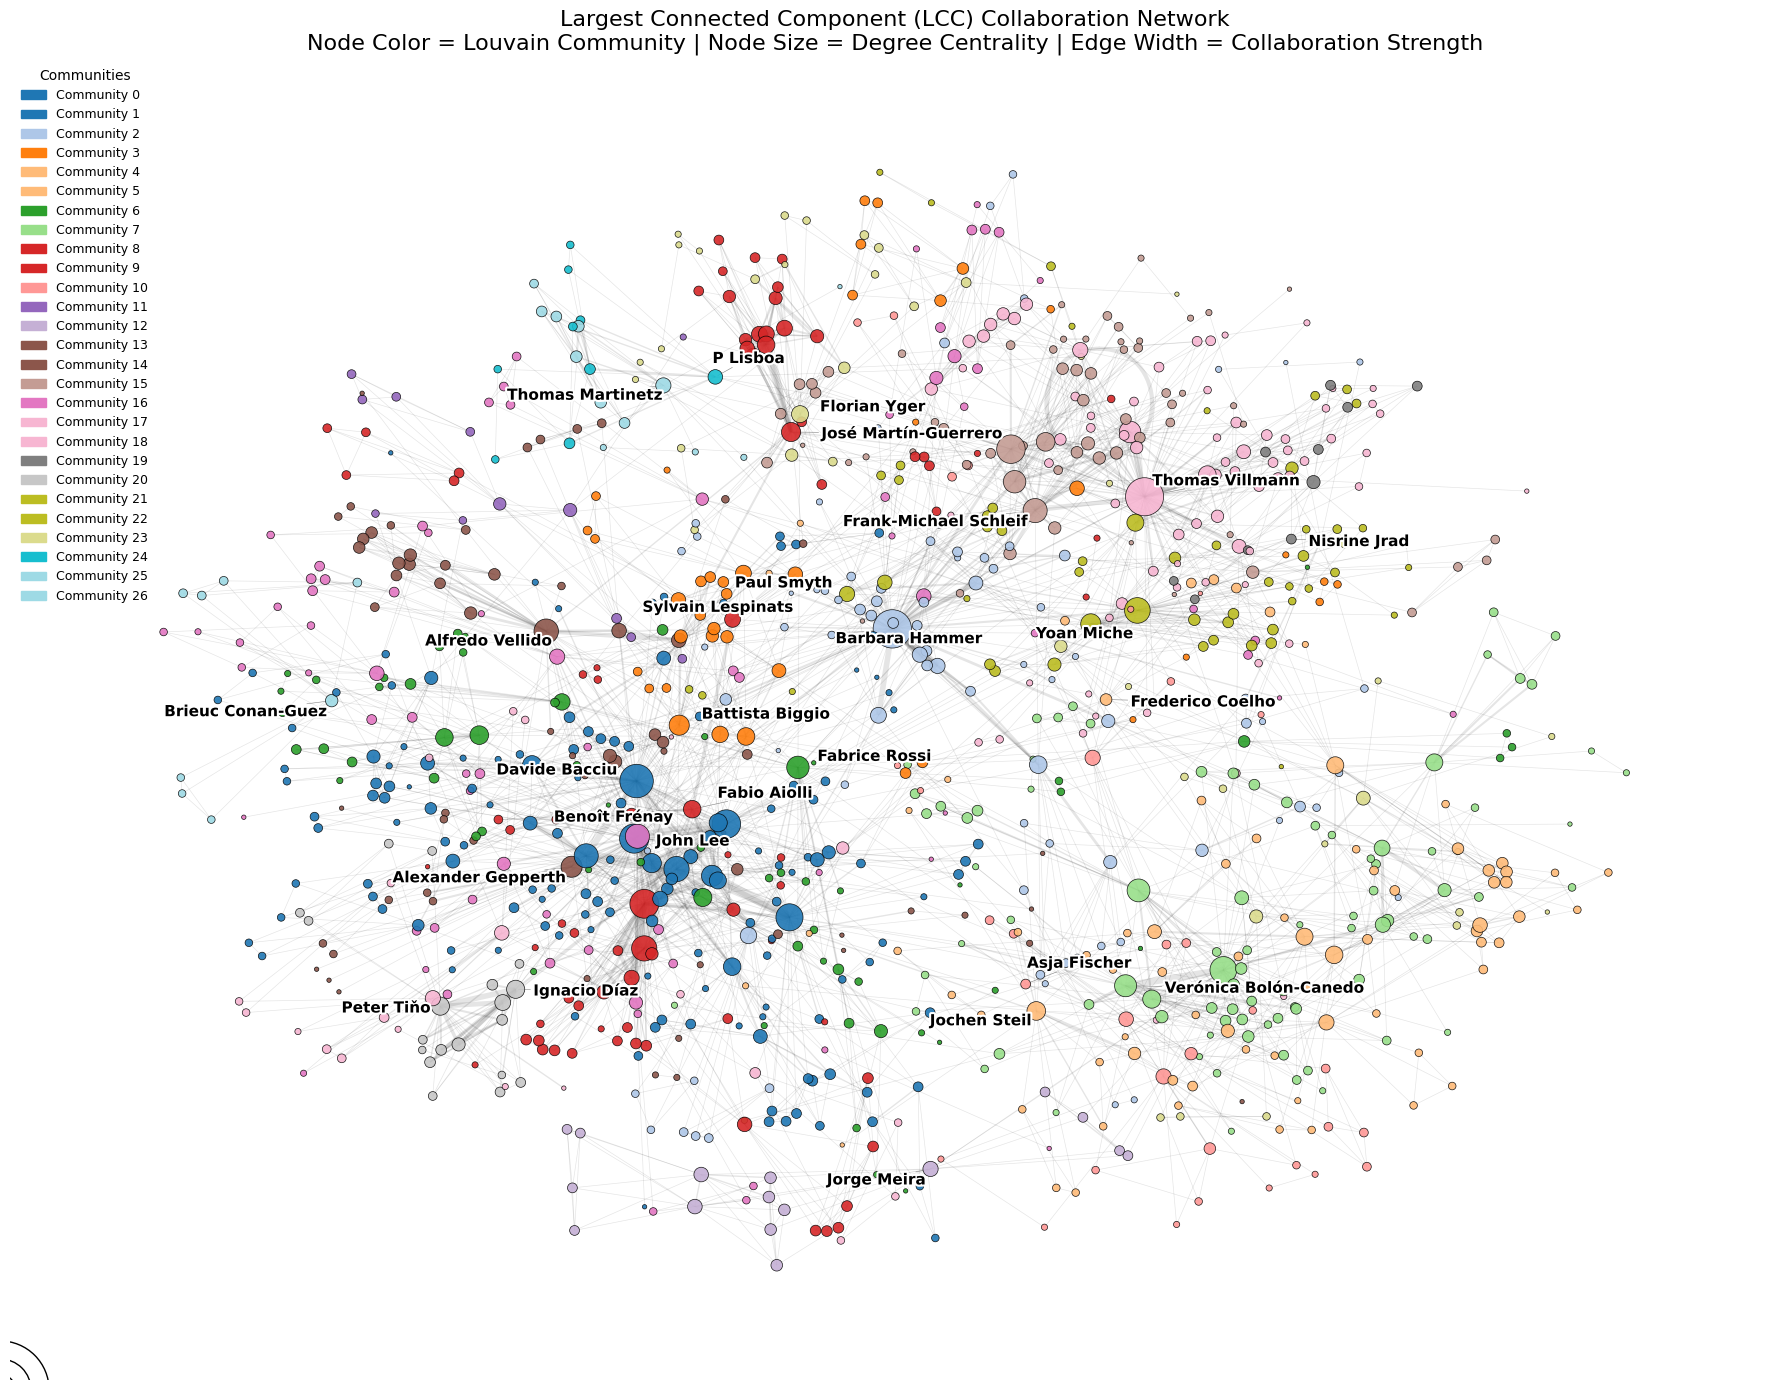

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
from adjustText import adjust_text

plt.rcParams['font.family'] = 'DejaVu Sans'  # Default Matplotlib sans serif


# ---- Ensure community attribute exists in G_lcc ----
community_dict = dict(zip(node_data["Author"], node_data["community"]))
nx.set_node_attributes(G_lcc, community_dict, "community")

degree_dict = dict(zip(node_data["Author"], node_data["degree_centrality"]))
betweenness_dict = dict(zip(node_data["Author"], node_data["betweenness_centrality"]))
nx.set_node_attributes(G_lcc, degree_dict, "degree_centrality")
nx.set_node_attributes(G_lcc, betweenness_dict, "betweenness_centrality")

# ---- Position nodes ----
pos = nx.spring_layout(G_lcc, k=0.15, iterations=50, seed=42)

# ---- Prepare attributes ----
degree_dict = nx.get_node_attributes(G_lcc, 'degree_centrality')
betweenness_dict = nx.get_node_attributes(G_lcc, 'betweenness_centrality')
community_dict = nx.get_node_attributes(G_lcc, 'community')

# ---- Color mapping ----
unique_comms = sorted(set(community_dict.values()))
color_map = plt.colormaps.get_cmap('tab20')
node_colors = [
    color_map(unique_comms.index(community_dict[node]) / max(1, len(unique_comms)-1))
    for node in G_lcc.nodes()
]

# ---- Node sizes ----
node_sizes = [degree_dict[node] * 35000 for node in G_lcc.nodes()]

# ---- Edge widths ----
edge_widths = [G_lcc[u][v]['weight'] * 0.5 for u, v in G_lcc.edges()]

# ---- Top 1 betweenness per community ----
top_labels_list = []
for comm_id in node_data["community"].unique():
    top_in_comm = (
        node_data[node_data["community"] == comm_id]
        .nlargest(1, "betweenness_centrality")["Author"]
        .tolist()
    )
    top_labels_list.extend(top_in_comm)

# ---- Plot ----
plt.figure(figsize=(18, 14))
plt.axis('off')

# Edges
nx.draw_networkx_edges(
    G_lcc, pos,
    alpha=0.1, width=edge_widths, edge_color="black"
)

# Nodes
nx.draw_networkx_nodes(
    G_lcc, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    edgecolors="black",
    linewidths=0.5
)

# ---- Improved Labels with adjustText ----
texts = []
for node in top_labels_list:
    x, y = pos[node]
    text = plt.text(
        x, y, node,
        fontsize=11, fontweight="bold", color="black",
        ha="center", va="center",
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )
    texts.append(text)

adjust_text(texts, 
            only_move={'points': 'y', 'texts': 'xy'}, 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.4))

# ---- Community legend ----
community_patches = [
    mpatches.Patch(color=color_map(i / max(1, len(unique_comms)-1)), label=f"Community {comm_id}")
    for i, comm_id in enumerate(unique_comms)
]

# ---- Node size legend ----
size_legend = [
    plt.scatter([], [], s=s, edgecolors="black", facecolors="none", label=f"{label}")
    for s, label in zip([500, 2000, 5000], ["Low", "Medium", "High"])
]

plt.legend(
    handles=community_patches,
    title="Communities",
    loc="upper left",
    fontsize=9,
    frameon=False
)

plt.title(
    "Largest Connected Component (LCC) Collaboration Network\n"
    "Node Color = Louvain Community | Node Size = Degree Centrality | Edge Width = Collaboration Strength",
    fontsize=16
)

plt.tight_layout()
plt.show()


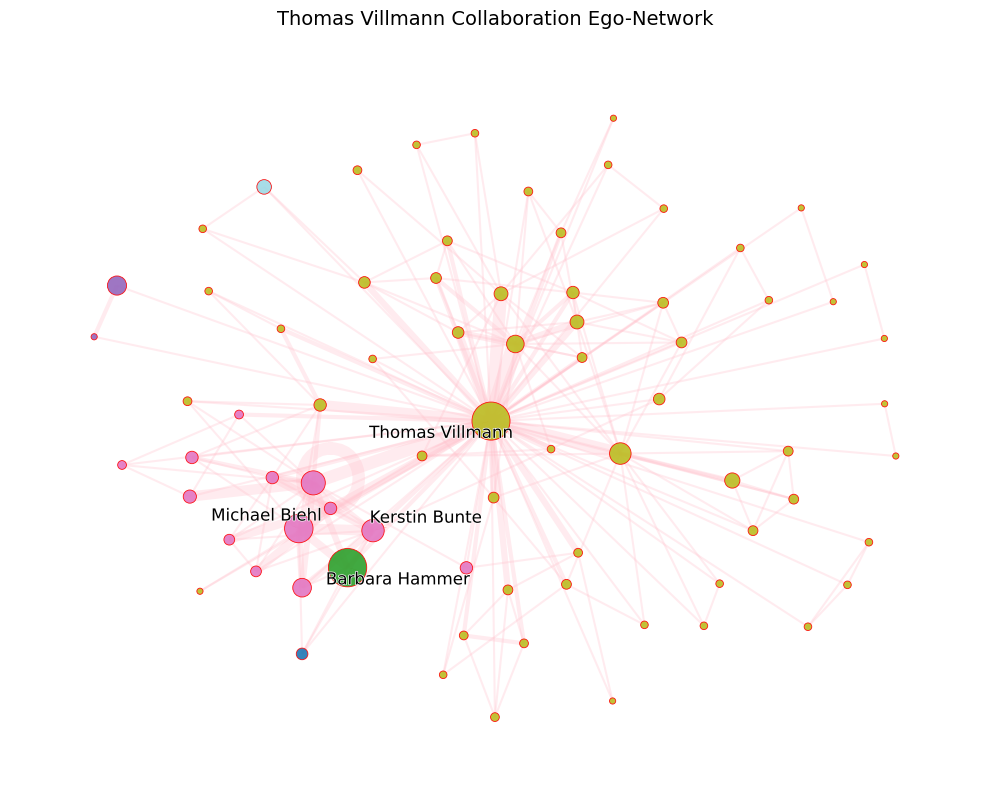

In [18]:
# ---- Extract Thomas Villmann's ego-network ----
ego_node = "Thomas Villmann"
ego_net = nx.ego_graph(G_lcc, ego_node, radius=1)  # 1-hop neighbors

# ---- Positions ----
pos_ego = nx.spring_layout(ego_net, k=0.4, iterations=50, seed=42)

# ---- Prepare attributes ----
ego_degree_dict = nx.get_node_attributes(ego_net, 'degree_centrality')
ego_comm_dict = nx.get_node_attributes(ego_net, 'community')

# Handle missing community values safely
ego_comm_list = [ego_comm_dict.get(node, -1) for node in ego_net.nodes()]
unique_comms_ego = sorted(set(ego_comm_list))

# Map node colors (gray for missing community)
ego_colors = []
for node in ego_net.nodes():
    comm = ego_comm_dict.get(node, -1)
    if comm == -1:
        ego_colors.append("pink")
    else:
        ego_colors.append(
            color_map(unique_comms_ego.index(comm) / max(1, len(unique_comms_ego)-1))
        )

# Node sizes
ego_sizes = [ego_degree_dict.get(node, 0.01) * 35000 for node in ego_net.nodes()]

# Edge widths (collaboration strength)
ego_edge_widths = [ego_net[u][v].get('weight', 1) * 1.5 for u, v in ego_net.edges()]

# ---- Plot ----
plt.figure(figsize=(10, 8))
plt.axis('off')

nx.draw_networkx_edges(
    ego_net, pos_ego,
    width=ego_edge_widths, alpha=0.3, edge_color="pink"
)

nx.draw_networkx_nodes(
    ego_net, pos_ego,
    node_color=ego_colors,
    node_size=ego_sizes,
    edgecolors="red",
    linewidths=0.6,
    alpha=0.9
)

# Labels (highlight Villmann + top collaborators)
labels_to_show = ["Thomas Villmann", "Barbara Hammer", "Michael Biehl", "Kerstin Bunte"]
texts = []
for node in labels_to_show:
    if node in ego_net:
        x, y = pos_ego[node]
        text = plt.text(
            x, y, node,
            fontsize=12,
            ha="center", va="center",
            path_effects=[path_effects.withStroke(linewidth=1, foreground="white")]
        )
        texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red", lw=0.1))

# ---- Community legend (only present ones) ----



plt.title(
    "Thomas Villmann Collaboration Ego-Network\n",
    fontsize=14
)

plt.tight_layout()
plt.show()


This is a collaboration network visualization—specifically of the Largest Connected Component (LCC) of a scholarly or research collaboration network. Here's a breakdown of what insights the plot conveys and how it's effectively telling a data-driven story:

🔍 What the Visualization Shows (Key Insights)
1. Collaboration Communities (Node Color)
Each node is colored by Louvain community detection, revealing tightly-knit collaboration clusters. These communities may represent:

Institutions or departments,

Research topic groups,

Geographic or national research clusters.

Insight: We can identify which researchers belong to the same thematic or social research groups.

2. Influential Researchers (Node Size = Degree Centrality)
Larger nodes have higher degree centrality, meaning they collaborate with many others.

Insight:

Felipe França, Davide Bacciu, Benoît Frénay, etc., are major collaboration hubs.

These individuals likely play key roles in bridging different research groups.

3. Collaboration Strength (Edge Width)
Thicker edges = stronger collaboration (likely more co-authored papers).

Insight:

Strong ties between certain individuals or communities suggest long-term or deeply integrated collaborations.

E.g., Felipe França has several thick connections, implying strong repeated collaborations.

4. Interconnectedness & Network Density
There are:

Dense areas = highly collaborative zones (e.g., center of the graph).

Sparse regions = isolated or less connected groups (edges of the graph).

Insight: The field has a large, interconnected core with a long tail of smaller, perhaps newer or more specialized researchers.

5. Bridge Builders & Cross-Community Connectors
Some researchers connect otherwise separate clusters (high betweenness centrality, though not shown directly, it can be inferred from their position and multiple thin edges to different colors).

Insight:

People like Barbara Hammer, Carlos Alzate, or Johan Suykens may act as key bridges between communities.

These individuals likely contribute to interdisciplinary or cross-topic collaboration.

✅ You’ve Already Completed:
Graph Construction

Author-author collaboration network.

Weighted by number of shared papers.

Centrality Measures

Degree, betweenness, closeness, eigenvector.

Combined score computed using normalized and weighted centralities.

Clustering Coefficient

You calculated both local and average clustering.

Found authors with high local clustering (dense local collaboration).

Largest Connected Component (LCC)

Extracted and analyzed LCC.

~72% of nodes are in the LCC (based on previous cells).

Analyzed LCC metrics: density, avg. shortest path, diameter, clustering.

Community Detection (Louvain)

Applied Louvain on LCC.

Assigned community IDs to authors.

Aggregated average centrality metrics per community.

Final Visualization

Gorgeous network graph:

Node size = degree centrality.

Node color = community.

Edge width = collaboration strength.

Labels for top betweenness author per community.

🧠 Insights from Your Network Analysis
🌐 1. Core Structure
The network has a dominant LCC indicating high global connectivity.

However, the diameter and average path length suggest some long-distance ties—possibly due to interdisciplinary or inter-institutional collaborations.

🧑‍🤝‍🧑 2. Communities
Louvain clustering has revealed clear sub-communities, likely aligned with:

Research areas,

Institutional clusters,

Or geographic/linguistic groups.

The breakdown by average centralities per community allows identification of influential communities.

🌟 3. Key Influencers
Authors with high betweenness centrality are crucial bridges between communities.

These are labeled in your graph—great for identifying connectors or potential collaboration facilitators.

🧠 4. Collaboration Patterns
Clustering coefficient reveals authors embedded in tightly-knit collaboration groups.

Authors with both high clustering and centrality are hubs in local communities.

🧩 5. Peripheral Components
The presence of many small isolated components shows there are disconnected or marginal research groups.

Your affiliation breakdown helps identify silos or under-integrated institutions.

In [19]:
# --- 1️⃣ Expand Author Lists for Metadata Mapping ---
#df['Author_List'] = df['Author_List'].apply(eval)  # Convert stringified lists to Python lists
authors_expanded = df[['Title', 'Author_List', 'Affiliations', 'topics']].explode('Author_List')
authors_expanded.rename(columns={'Author_List': 'Author'}, inplace=True)

# --- 2️⃣ Merge Louvain community info with metadata ---
merged_df = pd.merge(node_data, authors_expanded, on='Author', how='left')

# --- 3️⃣ Top Affiliations per Community ---
top_affiliations = (
    merged_df.groupby('community')['Affiliations']
    .apply(lambda x: pd.Series(x.dropna()).value_counts().head(3))
    .reset_index()
    .rename(columns={'level_1': 'Affiliation', 'Affiliations': 'Count'})
)

# --- 4️⃣ Top Research Topics per Community ---
top_topics = (
    merged_df.groupby('community')['topics']
    .apply(lambda x: pd.Series(x.dropna()).value_counts().head(3))
    .reset_index()
    .rename(columns={'level_1': 'Topic', 'topics': 'Count'})
)

# --- 5️⃣ View or Save ---
print("\n--- Top Affiliations per Community ---")
print(top_affiliations.head(10))

print("\n--- Top Topics per Community ---")
print(top_topics.head(10))

# Optional: Save to CSV
# top_affiliations.to_csv("top_affiliations_per_community.csv", index=False)
top_topics.to_csv("top_topics_per_community.csv", index=False)


--- Top Affiliations per Community ---
   community                                        Affiliation  Count
0          0  1 - Institut Agro Dijon -Laboratoire d'Informa...     15
1          0  1 - UCLouvain.be -IREC/MIRO Avenue Hippocrate ...      8
2          0  1 - University of Konstanz Germany\n2 - Univer...      7
3          1  1 - Department of Computer Science University ...     22
4          1  1 - Department of Computer Science University ...     14
5          1  1 - Department of Computer Science Università ...     11
6          2  1 - CITEC center of excellence Bielefeld Unive...     17
7          2  1 - Machine Learning Group Bielefeld Universit...      7
8          2  1 - Machine Learning Group Bielefeld Universit...      7
9          3  1 - SAILAB -University of Siena -via Roma 56 5...      9

--- Top Topics per Community ---
   community                                       Topic  Count
0          0       Dimensionality Reduction / Embeddings     49
1          0     

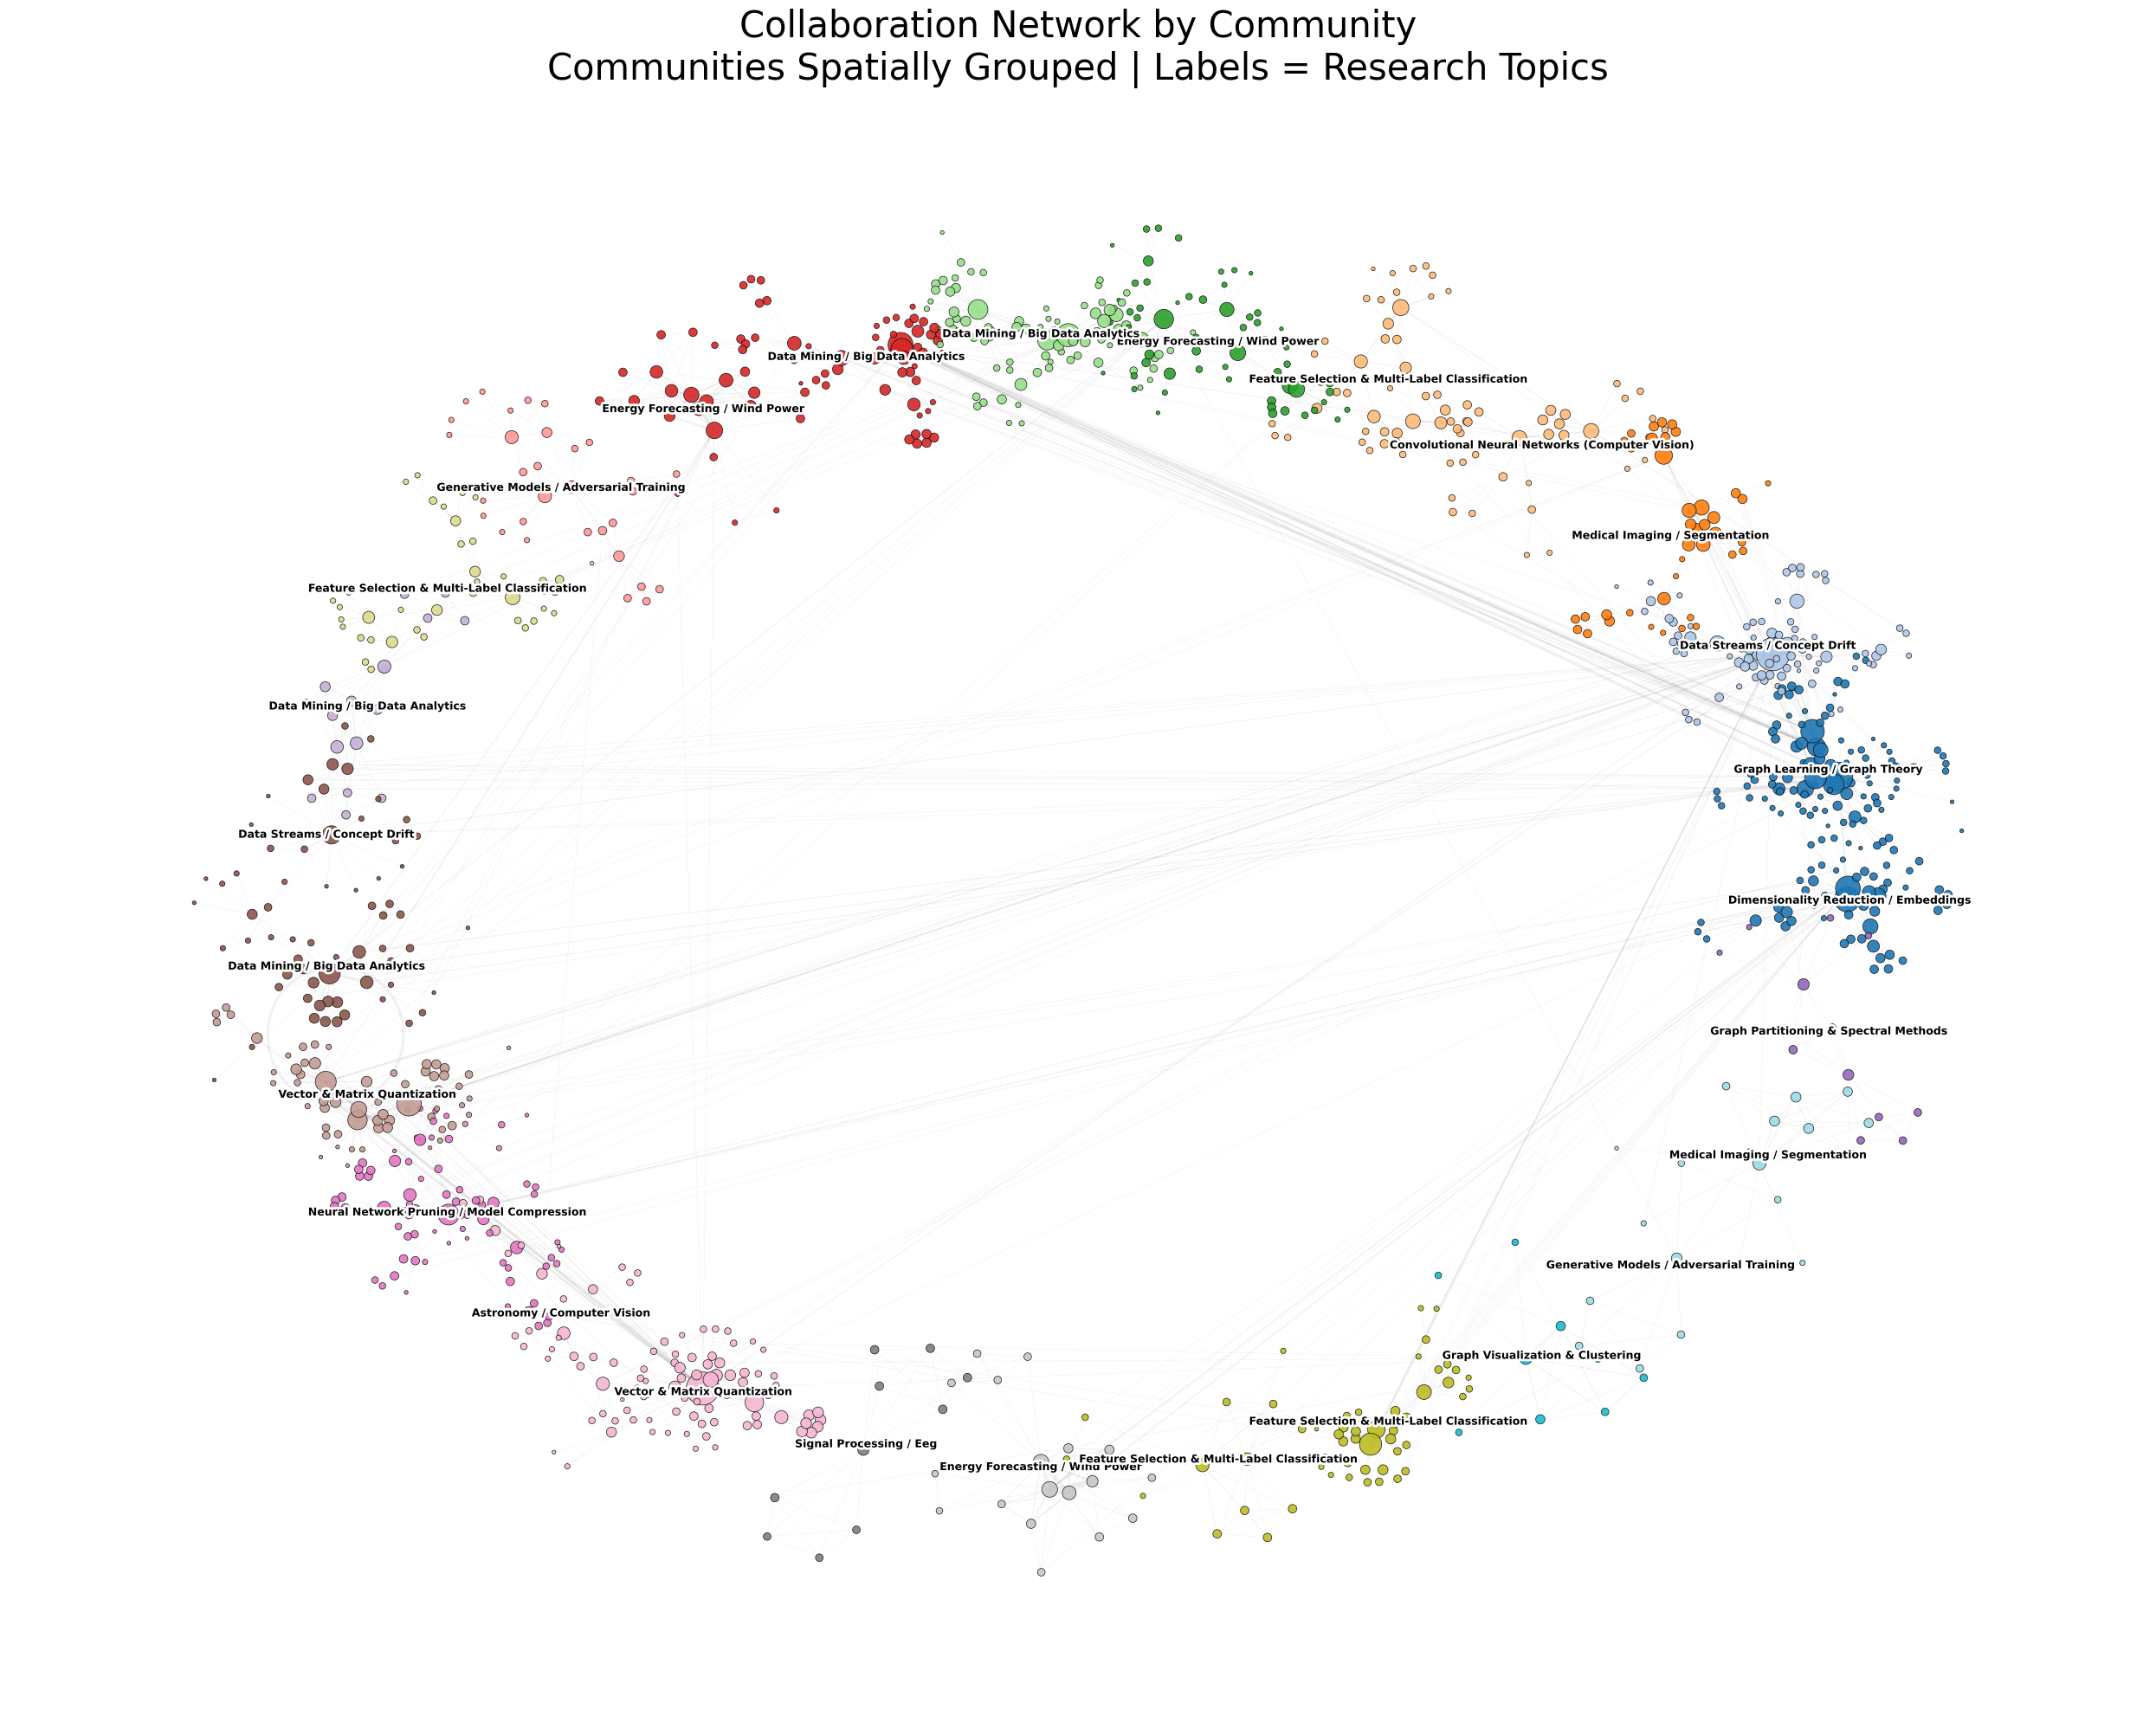

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
from collections import defaultdict
import numpy as np

# --- Get communities ---
community_dict = dict(zip(node_data["Author"], node_data["community"]))
nx.set_node_attributes(G_lcc, community_dict, "community")

# --- Build topic + affiliation summary labels ---
topic_dict = top_topics.sort_values('Count', ascending=False).drop_duplicates('community').set_index('community')['Topic'].to_dict()
affil_dict = top_affiliations.sort_values('Count', ascending=False).drop_duplicates('community').set_index('community')['Affiliation'].to_dict()
summary_labels = {
    comm_id: f"{topic_dict.get(comm_id, '').split(',')[0].title()} "
    for comm_id in sorted(set(community_dict.values()))
}

# --- Group nodes by community ---
community_nodes = defaultdict(list)
for node, comm_id in community_dict.items():
    community_nodes[comm_id].append(node)

# --- Community layout: place communities in circle ---
num_comms = len(community_nodes)
angle_step = 2 * np.pi / num_comms
radius = 5.0
community_centers = {
    comm_id: (
        radius * np.cos(i * angle_step),
        radius * np.sin(i * angle_step)
    )
    for i, comm_id in enumerate(community_nodes)
}

# --- Build composite layout ---
pos = {}
for comm_id, nodes in community_nodes.items():
    # Subgraph layout within each community
    subG = G_lcc.subgraph(nodes)
    sub_pos = nx.spring_layout(subG, k=0.25, iterations=50, seed=comm_id)

    # Shift sub-layout to community center
    cx, cy = community_centers[comm_id]
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + cx, y + cy)

# --- Color + size attributes ---
unique_comms = sorted(set(community_dict.values()))
color_map = plt.colormaps.get_cmap('tab20')
node_colors = [
    color_map(unique_comms.index(community_dict[node]) / max(1, len(unique_comms)-1))
    for node in G_lcc.nodes()
]
degree_dict = dict(zip(node_data["Author"], node_data["degree_centrality"]))
node_sizes = [degree_dict.get(node, 0) * 35000 for node in G_lcc.nodes()]
edge_widths = [G_lcc[u][v].get('weight', 1) * 0.4 for u, v in G_lcc.edges()]

# --- Plot ---
plt.figure(figsize=(25, 20))
plt.axis('off')

# Draw edges
nx.draw_networkx_edges(G_lcc, pos, alpha=0.1, width=edge_widths, edge_color="gray")

# Draw nodes
nx.draw_networkx_nodes(G_lcc, pos, node_color=node_colors, node_size=node_sizes,
                       edgecolors="black", linewidths=0.5, alpha=0.9)

# --- Add community summary labels at each group center ---
for comm_id, (cx, cy) in community_centers.items():
    label = summary_labels.get(comm_id, f"Community {comm_id}")
    plt.text(cx, cy, label, fontsize=9, ha="center", va="center",
             weight="bold", color="black",
             path_effects=[path_effects.withStroke(linewidth=4, foreground="white")])

# --- Title ---
plt.title(
    "Collaboration Network by Community\n"
    "Communities Spatially Grouped | Labels = Research Topics",
    fontsize=30
)

plt.tight_layout()
plt.show()


1. Each cluster represents a distinct collaboration community with a coherent research theme, such as:

“Structured Learning”

“Wind Forecasting”

“Feature Selection”

“Deep Graph”

This reveals thematic structure within the broader collaboration network.
2. Topic diffusion across communities
You observe the same research topic in multiple separate communities (e.g., “Structured Learning” in ~5 places).

➤ Insight:
Some topics are highly distributed across disconnected collaboration groups.

This implies methodological popularity, disciplinary overlap, or geographic fragmentation.

You can further explore:

Are these communities in different countries or institutions?

Are they applying the same topic in different domains?

3. Community modularity = Collaboration silos
Louvain clustering grouped researchers based on collaboration strength, and your spatial layout reflects that.

➤ Insight:
Communities are highly modular: intra-community links are dense, inter-community links are sparse.

Suggests strong institutional, departmental, or regional silos.

You can analyze:

Whether collaboration is clustered by affiliation, language, conference track, etc.

4. Dominant research areas in the network
By labeling communities with their dominant topics, you now quantify the landscape of your conference or field.

➤ Insight:
The network contains recurring core themes: structured learning, feature selection, wind forecasting, etc.

These can inform:

Session tracks in conferences

Funding or collaboration opportunities

Trend analysis over time

5. Research themes vs. collaboration communities ≠ same
You now have visual proof that:

Collaboration-based communities and research-topic-based communities don’t fully overlap.

➤ Insight:
Louvain communities are based on who collaborates with whom — social/professional structure.

Topics are based on what they write about — semantic structure.

You can study where they diverge, which gives insight into:

Multi-institutional collaboration

Competing research groups on the same topic

Lack of cross-pollination

6. Structural layout = Strategic insight
Your circular community layout highlights:

Which communities are large

Which are peripheral

Where potential bridges could be built

➤ Insight:
Some communities are highly central (e.g., “Structured Learning”) → more integrated

Others are peripheral → niche or isolated research areas

This can inform:

Conference planning (e.g., who to bring together)

Outreach to underrepresented research areas

Integration strategy: fostering inter-community collaboration

7. Inter-community thematic overlap
Because some topics appear in multiple communities, you now have a basis for cross-community link analysis.

➤ Insight:
You can identify communities with same topics but no links — missed collaboration potential

Or communities with strong links and shared topics — strong field cohesion

This informs:

Bridge-building workshops

Joint special issues

Strategic networking

8. Detecting emerging vs. established communities
Some labeled communities are large and connected, while others are smaller.

➤ Insight:
Larger communities with well-defined topics = mature research themes

Smaller, newer clusters = possibly emerging research topics

You can:

Track growth over time

Highlight rising areas

Detect fragmentation or merging trends

9. Research density per theme
You now have a quantitative view of how much collaboration exists in each topic area.

➤ Insight:
High-density clusters = active research ecosystems

Sparse or fragmented topic-labeled communities = either:

Less collaboration

Or broader, disjointed application areas

This aligns with evaluating research strength and cohesion per topic.

10. Conference session & program design
This graph supports topic-based clustering of authors for:

Conference session planning

Reviewing assignments

Workshop creation

Instead of relying purely on submitted keywords, you now have:

Structural insight into who collaborates

And semantic labels based on dominant research



In [22]:
# Temporal Analysis

In [23]:
# Ensure year column is integer
df['Year'] = df['Year'].astype(int)

# Get all unique years sorted
years = sorted(df['Year'].unique())
print("Years in dataset:", years)


Years in dataset: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [24]:
#Build Yearly Networks

import networkx as nx
from itertools import combinations

yearly_graphs = {}

for y in years:
    df_year = df[df['Year'] == y]
    
    G_year = nx.Graph()
    
    # Build graph for that year
    for authors in df_year['Author_List']:
        for a1, a2 in combinations(authors, 2):
            if G_year.has_edge(a1, a2):
                G_year[a1][a2]['weight'] += 1
            else:
                G_year.add_edge(a1, a2, weight=1)
    
    yearly_graphs[y] = G_year
    print(f"Year {y}: {G_year.number_of_nodes()} authors, {G_year.number_of_edges()} collaborations")


Year 2010: 222 authors, 326 collaborations
Year 2011: 214 authors, 316 collaborations
Year 2012: 304 authors, 496 collaborations
Year 2013: 251 authors, 430 collaborations
Year 2014: 307 authors, 441 collaborations
Year 2015: 266 authors, 440 collaborations
Year 2016: 329 authors, 591 collaborations
Year 2017: 338 authors, 613 collaborations
Year 2018: 327 authors, 511 collaborations
Year 2019: 317 authors, 591 collaborations
Year 2020: 344 authors, 601 collaborations
Year 2021: 318 authors, 542 collaborations
Year 2022: 269 authors, 558 collaborations
Year 2023: 335 authors, 642 collaborations
Year 2024: 371 authors, 688 collaborations
Year 2025: 406 authors, 770 collaborations


In [25]:
#Community Detection per Year

In [26]:
#using Louvain
import community as community_louvain

yearly_communities = {}

for y, G_year in yearly_graphs.items():
    if len(G_year) > 0:
        partition = community_louvain.best_partition(G_year, weight='weight')
        yearly_communities[y] = partition
        
        # Add community as node attribute
        nx.set_node_attributes(G_year, partition, "community")
        
        print(f"Year {y}: {len(set(partition.values()))} communities detected")


Year 2010: 60 communities detected
Year 2011: 55 communities detected
Year 2012: 70 communities detected
Year 2013: 62 communities detected
Year 2014: 81 communities detected
Year 2015: 65 communities detected
Year 2016: 71 communities detected
Year 2017: 82 communities detected
Year 2018: 77 communities detected
Year 2019: 73 communities detected
Year 2020: 76 communities detected
Year 2021: 67 communities detected
Year 2022: 57 communities detected
Year 2023: 69 communities detected
Year 2024: 75 communities detected
Year 2025: 85 communities detected


In [27]:
#Compute Network Metrics Over time
metrics_over_time = []

for y, G_year in yearly_graphs.items():
    if len(G_year) == 0:
        continue
    
    avg_degree = sum(dict(G_year.degree()).values()) / G_year.number_of_nodes()
    density = nx.density(G_year)
    clustering = nx.average_clustering(G_year, weight='weight')
    
    metrics_over_time.append({
        "Year": y,
        "Nodes": G_year.number_of_nodes(),
        "Edges": G_year.number_of_edges(),
        "Avg_Degree": avg_degree,
        "Density": density,
        "Clustering": clustering,
        "Communities": len(set(nx.get_node_attributes(G_year, "community").values()))
    })

metrics_df = pd.DataFrame(metrics_over_time)
print(metrics_df)


    Year  Nodes  Edges  Avg_Degree   Density  Clustering  Communities
0   2010    222    326    2.936937  0.013289    0.264045           60
1   2011    214    316    2.953271  0.013865    0.129477           55
2   2012    304    496    3.263158  0.010769    0.287838           70
3   2013    251    430    3.426295  0.013705    0.207884           62
4   2014    307    441    2.872964  0.009389    0.279512           81
5   2015    266    440    3.308271  0.012484    0.306241           65
6   2016    329    591    3.592705  0.010953    0.231024           71
7   2017    338    613    3.627219  0.010763    0.422203           82
8   2018    327    511    3.125382  0.009587    0.286383           77
9   2019    317    591    3.728707  0.011800    0.415344           73
10  2020    344    601    3.494186  0.010187    0.271040           76
11  2021    318    542    3.408805  0.010753    0.288250           67
12  2022    269    558    4.148699  0.015480    0.298369           57
13  2023    335    6

Insights from your table:

Author Participation (Nodes)

Grew from ~220 (2010) to 406 (2025).

This suggests the conference is attracting more researchers over time.

Collaborations (Edges)

Increased from ~326 (2010) to 770 (2025).

Collaboration intensity is clearly rising.

Average Degree

Starts around 2.9 → rises to ~3.7–4.1 after 2020.

Meaning: authors are collaborating with more co-authors on average in recent years.

Density

Stays very low (~0.009–0.015).

Networks are sparse → most authors collaborate with only a few others, which is typical in academic networks.

Slight peak in 2022 (0.015), suggesting a temporary surge in interconnectedness.

Clustering Coefficient

Fluctuates but shows a big spike in 2017 (0.42).

That year, collaborations were highly clustered into tight-knit groups.

Otherwise, it hovers ~0.26–0.31, meaning moderate local collaboration triangles.

Communities

Between 55–84 each year.

A high number of communities relative to nodes → collaboration is fragmented into many small groups.

2025 has the most communities (84), suggesting more research sub-groups emerging.




Story you can tell:

Over 15 years, the ESANN community has grown steadily in both participation and collaborations.

While collaborations are increasing, the network remains sparse, showing the conference is still diverse and not dominated by a single “giant clique.”

Certain years (2017, 2019) show stronger clustering, indicating waves of intensive intra-group collaboration.

The rise in communities by 2025 suggests new subfields/topics are forming, which aligns well with your embedding/topic clusters.

In [28]:
#Track Community Evolution (Later, you can compare Jaccard similarity of communities between years) for 2019 <--> 2020
from collections import defaultdict

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

# Example: compare communities between 2019 and 2020
comm_2019 = defaultdict(set)
for node, comm in yearly_communities[2019].items():
    comm_2019[comm].add(node)

comm_2020 = defaultdict(set)
for node, comm in yearly_communities[2020].items():
    comm_2020[comm].add(node)

for c1, members1 in comm_2019.items():
    for c2, members2 in comm_2020.items():
        sim = jaccard_similarity(members1, members2)
        if sim > 0.2:  # threshold for "continuity"
            print(f"Community {c1} in 2019 ↔ Community {c2} in 2020: Jaccard={sim:.2f}")


Community 1 in 2019 ↔ Community 1 in 2020: Jaccard=0.27
Community 6 in 2019 ↔ Community 34 in 2020: Jaccard=0.35
Community 10 in 2019 ↔ Community 36 in 2020: Jaccard=1.00
Community 19 in 2019 ↔ Community 75 in 2020: Jaccard=0.22
Community 22 in 2019 ↔ Community 13 in 2020: Jaccard=0.67
Community 25 in 2019 ↔ Community 29 in 2020: Jaccard=0.40
Community 33 in 2019 ↔ Community 53 in 2020: Jaccard=0.67
Community 49 in 2019 ↔ Community 21 in 2020: Jaccard=0.50
Community 62 in 2019 ↔ Community 72 in 2020: Jaccard=0.60


In [29]:
#Track Community Evolution (Later, you can compare Jaccard similarity of communities between years) for 2010 <--> 2011
from collections import defaultdict

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

# Example: compare communities between 2019 and 2020
comm_2019 = defaultdict(set)
for node, comm in yearly_communities[2010].items():
    comm_2019[comm].add(node)

comm_2020 = defaultdict(set)
for node, comm in yearly_communities[2011].items():
    comm_2020[comm].add(node)

for c1, members1 in comm_2019.items():
    for c2, members2 in comm_2020.items():
        sim = jaccard_similarity(members1, members2)
        if sim > 0.2:  # threshold for "continuity"
            print(f"Community {c1} in 2010 ↔ Community {c2} in 2011: Jaccard={sim:.2f}")


Community 0 in 2010 ↔ Community 44 in 2011: Jaccard=1.00
Community 34 in 2010 ↔ Community 2 in 2011: Jaccard=0.24
Community 9 in 2010 ↔ Community 3 in 2011: Jaccard=0.67
Community 13 in 2010 ↔ Community 9 in 2011: Jaccard=0.50
Community 20 in 2010 ↔ Community 18 in 2011: Jaccard=0.25
Community 37 in 2010 ↔ Community 13 in 2011: Jaccard=0.50
Community 38 in 2010 ↔ Community 32 in 2011: Jaccard=0.25
Community 50 in 2010 ↔ Community 34 in 2011: Jaccard=0.75


Stable/Continuing Communities

Community 10 (2019) ↔ Community 36 (2020): Jaccard=1.00
→ This group persisted unchanged — the same people collaborated across both years.
Likely a long-standing research team working on a consistent line of work.

Community 22 (2019) ↔ Community 13 (2020): Jaccard=0.67

Community 33 (2019) ↔ Community 53 (2020): Jaccard=0.67
→ These show strong continuity, with ~2/3 of members retained.
Indicates stable labs/affiliations with some new joiners or leavers.

Partially Evolving Communities

Community 6 ↔ 34: 0.35

Community 25 ↔ 29: 0.40

Community 49 ↔ 21: 0.50

Community 62 ↔ 72: 0.60
→ These represent communities that evolved — some members stayed, others split off, maybe merged with different groups.
This could signal topic shifts or collaborations across labs.

Weak but Real Continuity

Community 1 ↔ 1: 0.27

Community 19 ↔ 75: 0.22
→ A core group survived, but most members changed.
Suggests the old group fragmented, with only a subset carrying forward.

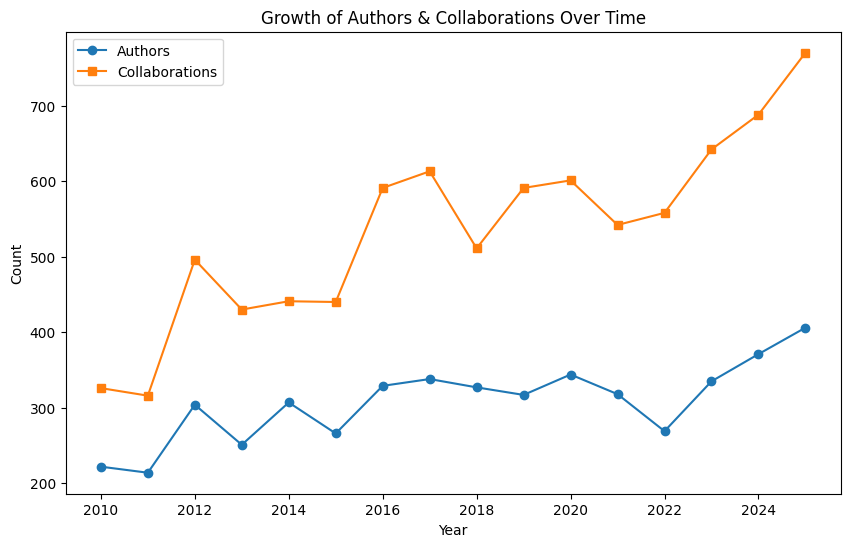

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(metrics_df["Year"], metrics_df["Nodes"], marker="o", label="Authors")
plt.plot(metrics_df["Year"], metrics_df["Edges"], marker="s", label="Collaborations")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Growth of Authors & Collaborations Over Time")
plt.legend()
plt.show()


In [31]:
from collections import defaultdict
import pandas as pd

def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

links = []  # store continuity links

# Loop across all consecutive year pairs
for i in range(len(years)-1):
    y1, y2 = years[i], years[i+1]
    comm_y1, comm_y2 = defaultdict(set), defaultdict(set)
    
    # Collect members of each community
    for node, comm in yearly_communities[y1].items():
        comm_y1[comm].add(node)
    for node, comm in yearly_communities[y2].items():
        comm_y2[comm].add(node)
    
    # Compare communities between y1 and y2
    for c1, members1 in comm_y1.items():
        for c2, members2 in comm_y2.items():
            sim = jaccard_similarity(members1, members2)
            if sim > 0.2:  # threshold for "continuity"
                links.append({
                    "Year1": y1,
                    "Community1": c1,
                    "Year2": y2,
                    "Community2": c2,
                    "Jaccard": sim,
                    "Size1": len(members1),
                    "Size2": len(members2)
                })

# Convert to DataFrame
temporal_df = pd.DataFrame(links)

# Show first few rows
print(temporal_df.head())

# Save for later analysis/visualization
temporal_df.to_csv("temporal_evolution.csv", index=False)


   Year1  Community1  Year2  Community2   Jaccard  Size1  Size2
0   2010           0   2011          44  1.000000      2      2
1   2010          34   2011           2  0.241379     16     20
2   2010           9   2011           3  0.666667      3      2
3   2010          13   2011           9  0.500000      3      3
4   2010          20   2011          18  0.250000     13     12


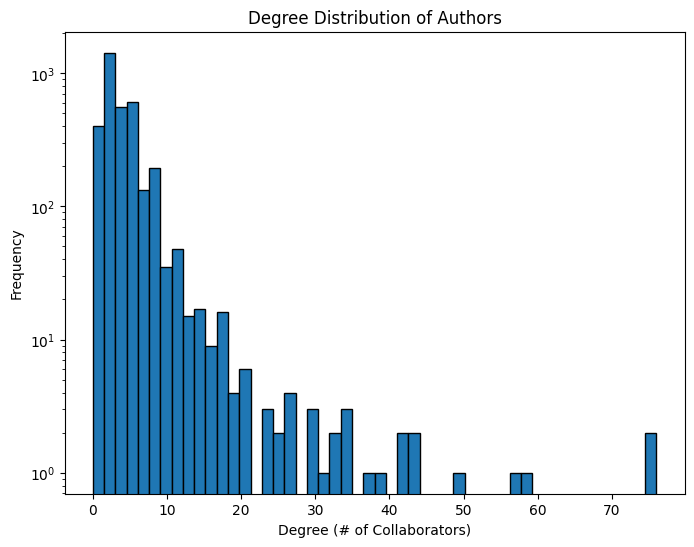

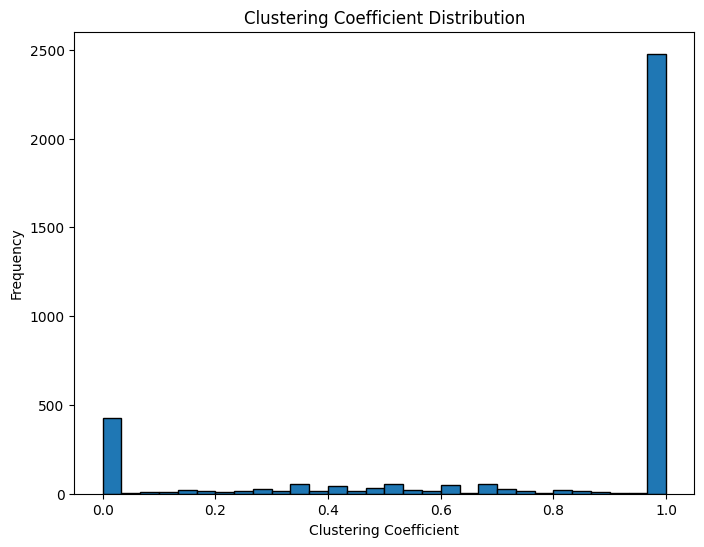

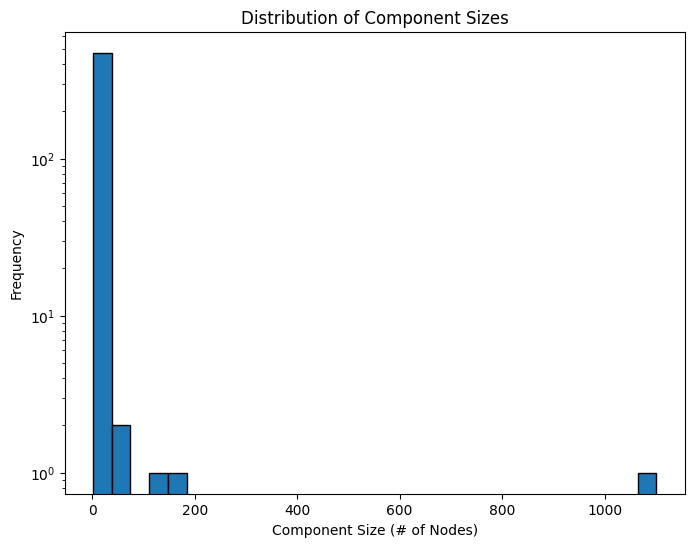

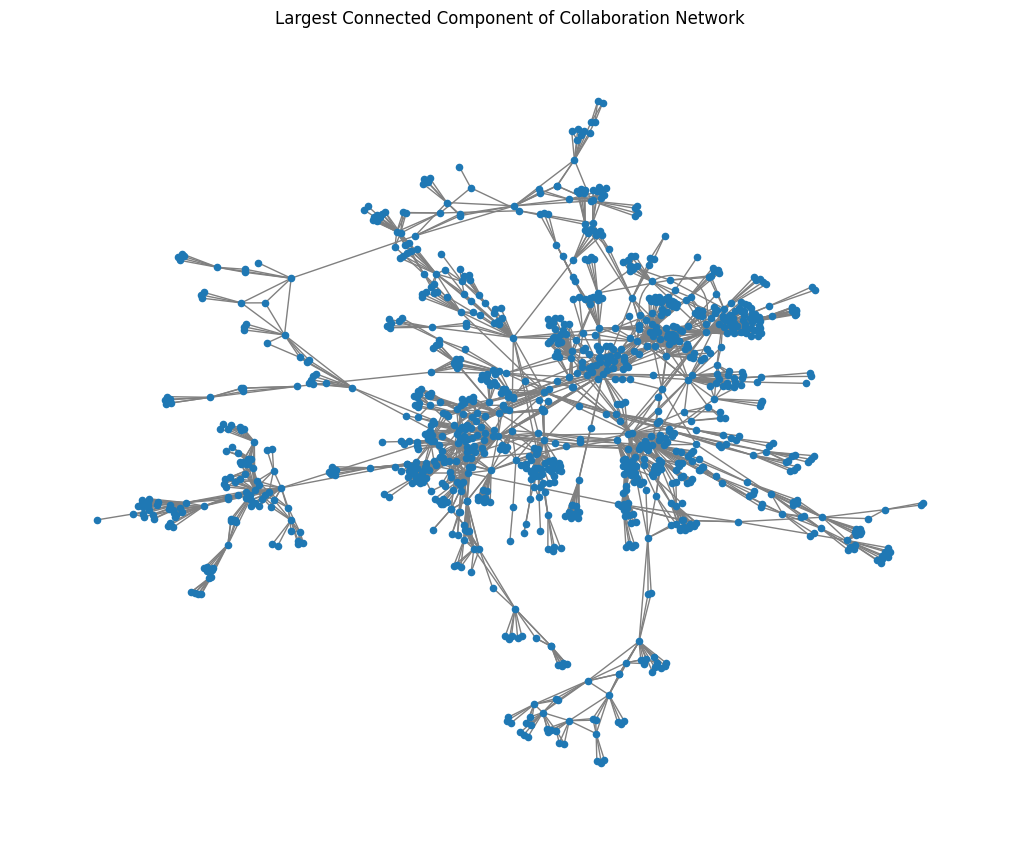

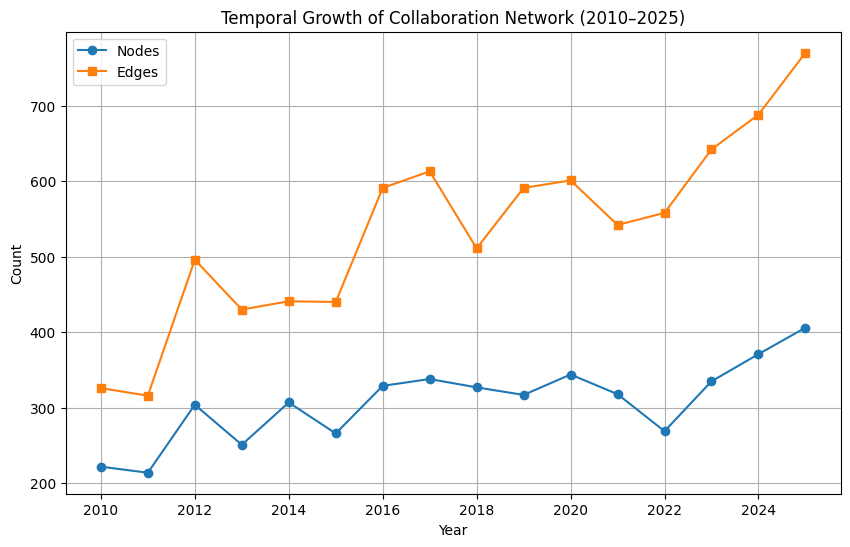

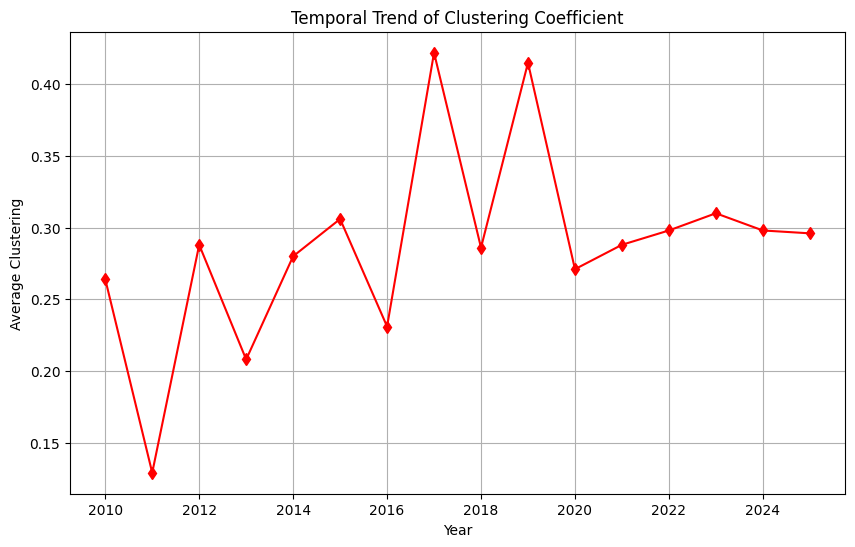

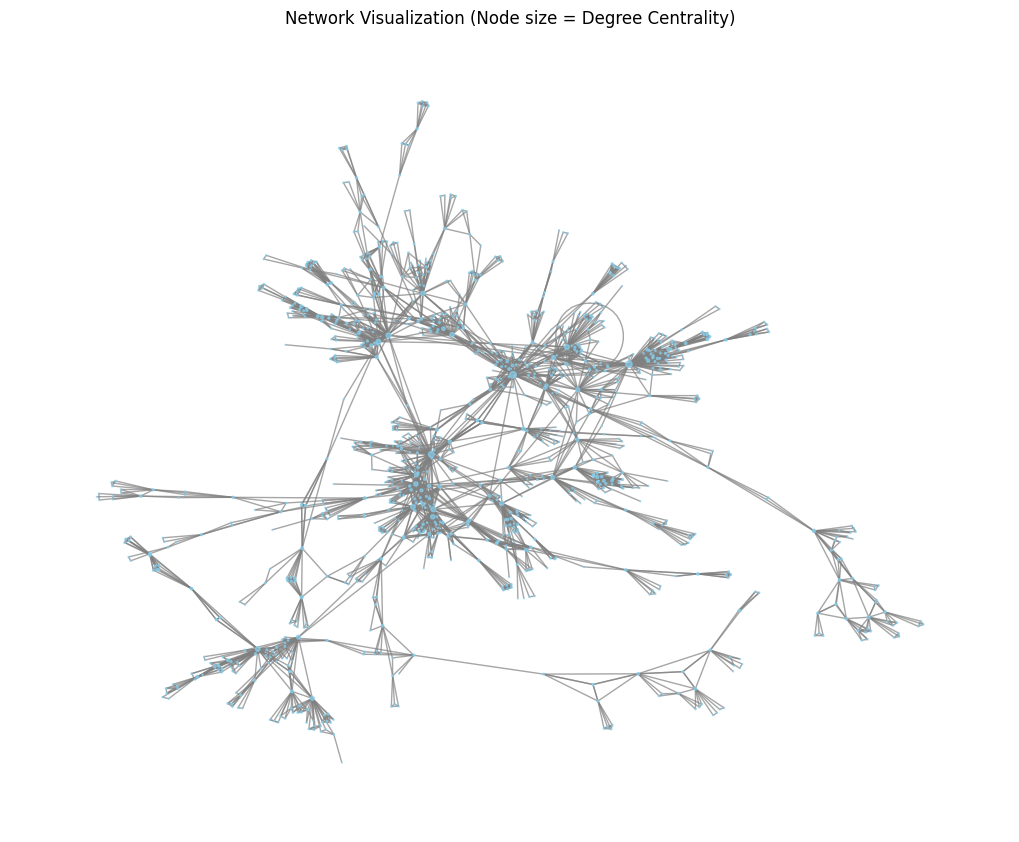

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Degree Distribution ===
degrees = [d for n, d in G.degree()]
plt.figure(figsize=(8,6))
plt.hist(degrees, bins=50, edgecolor='black')
plt.title("Degree Distribution of Authors")
plt.xlabel("Degree (# of Collaborators)")
plt.ylabel("Frequency")
plt.yscale("log")  # often degree distributions are heavy-tailed
plt.show()


# === 2. Clustering Coefficient Distribution ===
clustering = nx.clustering(G)  # dict of node -> coefficient
plt.figure(figsize=(8,6))
plt.hist(list(clustering.values()), bins=30, edgecolor='black')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.show()


# === 3. Component Size Distribution ===
components = [len(c) for c in nx.connected_components(G)]
plt.figure(figsize=(8,6))
plt.hist(components, bins=30, edgecolor='black')
plt.title("Distribution of Component Sizes")
plt.xlabel("Component Size (# of Nodes)")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

# Optional: Visualise Largest Connected Component
LCC = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(LCC).copy()
plt.figure(figsize=(10,8))
nx.draw_spring(G_lcc, node_size=20, edge_color="gray")
plt.title("Largest Connected Component of Collaboration Network")
plt.show()


# === 4. Temporal Evolution ===
# Assuming you have a dataframe `df_yearly` with columns:
# Year, Nodes, Edges, Avg_Degree, Density, Clustering, Communities
# (from your extracted outputs)

# Example: reconstruct from your output table
data = {
    "Year": [2010,2011,2012,2013,2014,2015,2016,2017,2018,
             2019,2020,2021,2022,2023,2024,2025],
    "Nodes": [222,214,304,251,307,266,329,338,327,317,344,318,269,335,371,406],
    "Edges": [326,316,496,430,441,440,591,613,511,591,601,542,558,642,688,770],
    "Clustering": [0.264,0.129,0.288,0.208,0.280,0.306,0.231,0.422,0.286,
                   0.415,0.271,0.288,0.298,0.310,0.298,0.296]
}
df_yearly = pd.DataFrame(data)

plt.figure(figsize=(10,6))
plt.plot(df_yearly["Year"], df_yearly["Nodes"], marker="o", label="Nodes")
plt.plot(df_yearly["Year"], df_yearly["Edges"], marker="s", label="Edges")
plt.title("Temporal Growth of Collaboration Network (2010–2025)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df_yearly["Year"], df_yearly["Clustering"], marker="d", color="red")
plt.title("Temporal Trend of Clustering Coefficient")
plt.xlabel("Year")
plt.ylabel("Average Clustering")
plt.grid(True)
plt.show()


# === 5. Centrality Highlight Plots ===
# Example: visualize network with node size proportional to centrality
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=500)  # sample for speed

plt.figure(figsize=(10,8))
nx.draw_spring(
    G_lcc,
    node_size=[1000*degree_centrality[n] for n in G_lcc],
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7
)
plt.title("Network Visualization (Node size = Degree Centrality)")
plt.show()
